# Evaluate Trainings

## Setup

In [ ]:
import json
import matplotlib.pyplot as plt
import polars as pl

from config import MODELS, RUN_ID, NUM_CLASSES
from typing import Any
from privacy_and_grokking.path_keeper import get_path_keeper

In [3]:
def flatten_dict(d: dict[str, Any], parent_key: str = "", sep: str = "_") -> dict[str, Any]:
    items: list[tuple[str, Any]] = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [4]:
pk = get_path_keeper()
pk.set_params({"run_id": RUN_ID})

## Visualizations

### Training

In [5]:
dfs = {}
for model in MODELS:
    pk.set_params({"model": model.config.name})
    metrics: list[dict] = json.loads(pk.TRAIN_METRICS.read_text())
    metrics = [flatten_dict(m) for m in metrics]
    df = pl.DataFrame(metrics)
    dfs[model.config.name] = df

In [6]:
dfs[list(dfs.keys())[0]].head()

step,train_loss,train_accuracy,test_loss,test_accuracy,norm,last_layer_norm
i64,f64,f64,f64,f64,f64,f64
0,0.00051,0.091009,0.000513,0.0878,11.724171,1.851343
1,0.000411,0.359503,0.000412,0.3497,11.728654,1.848042
2,0.000369,0.544654,0.000368,0.55,11.73809,1.84615
3,0.000331,0.636664,0.000329,0.6507,11.749284,1.844947
4,0.000299,0.691169,0.000297,0.7049,11.762516,1.844635


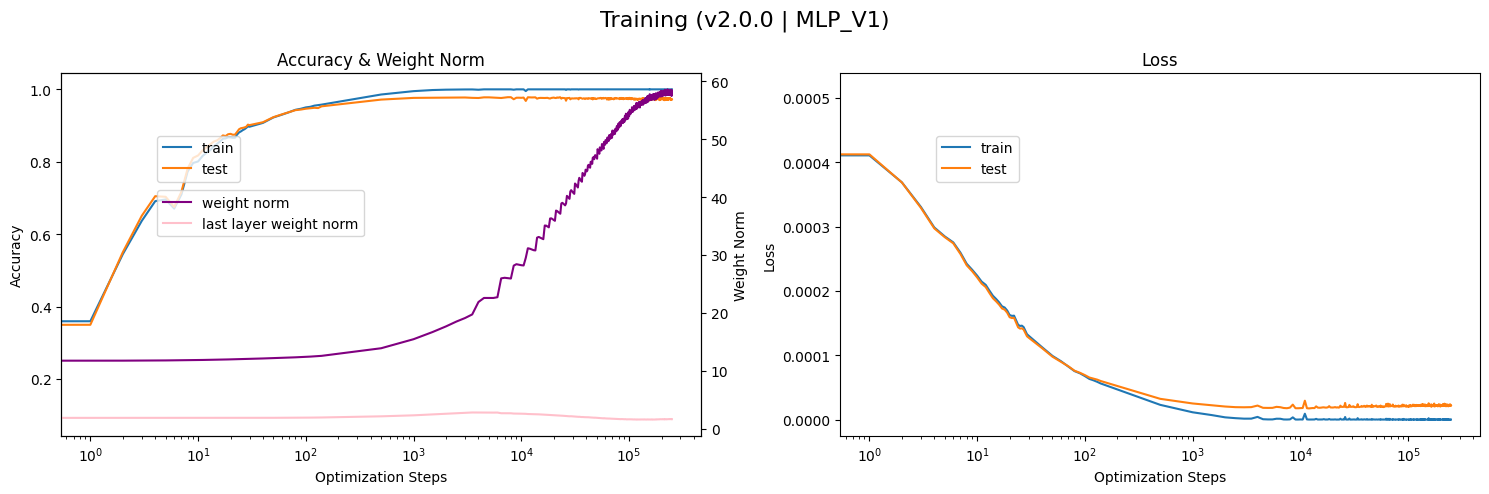

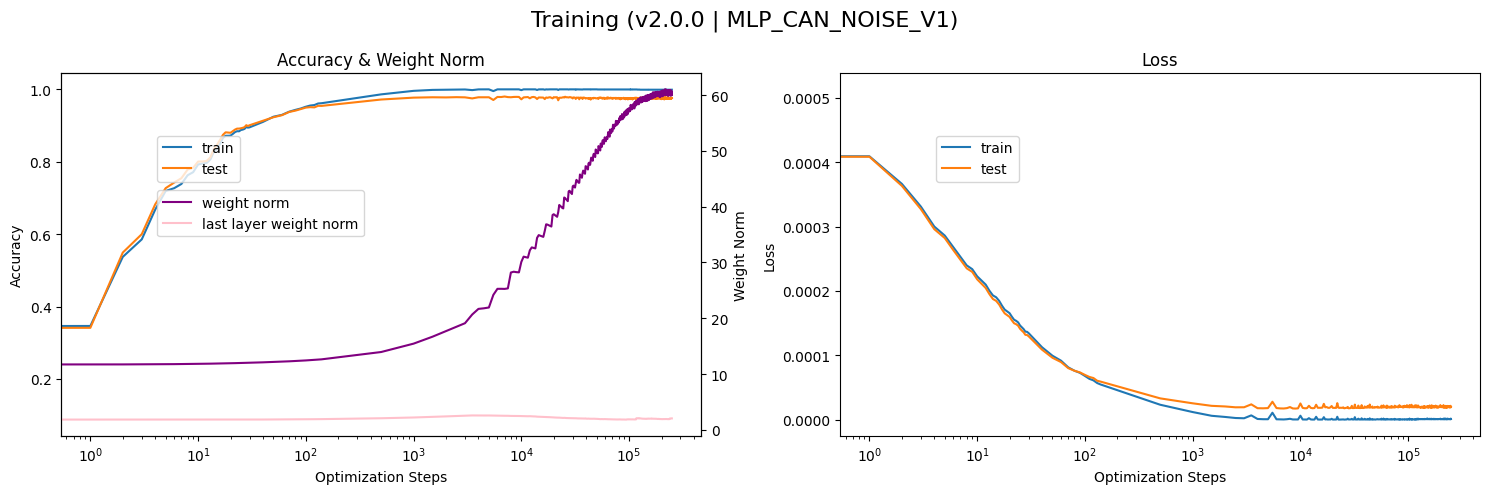

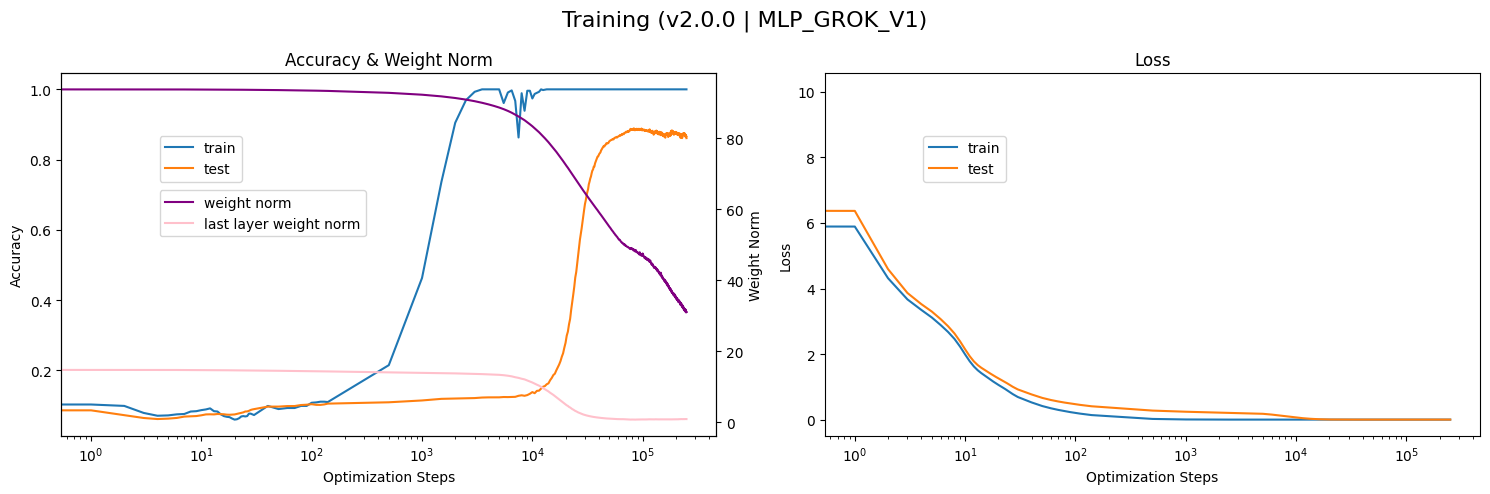

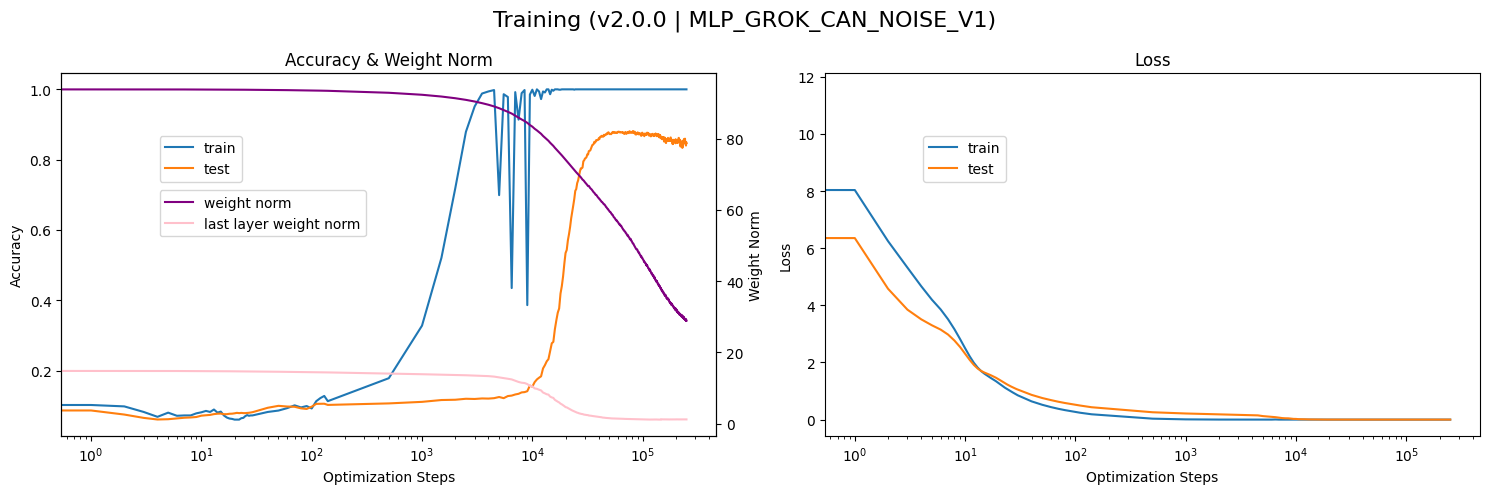

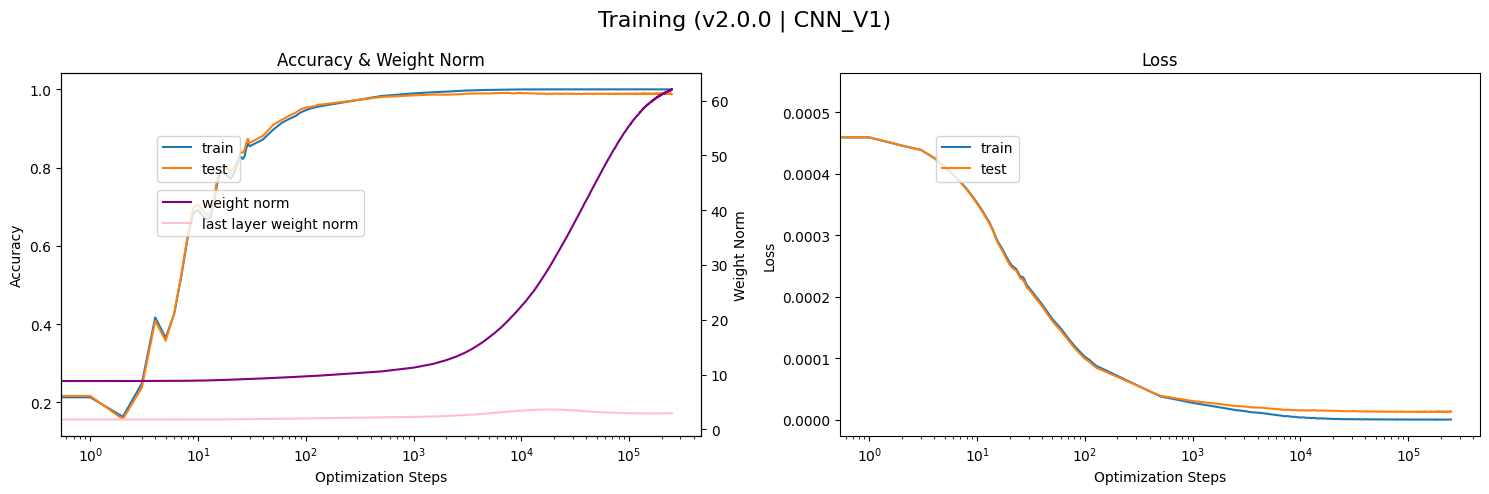

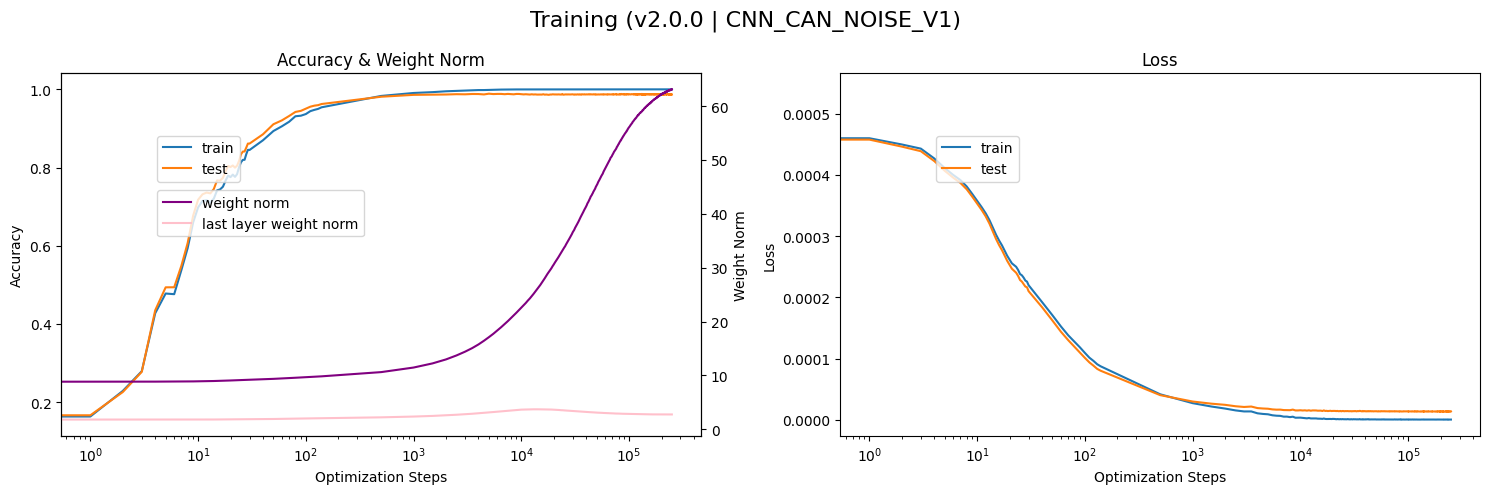

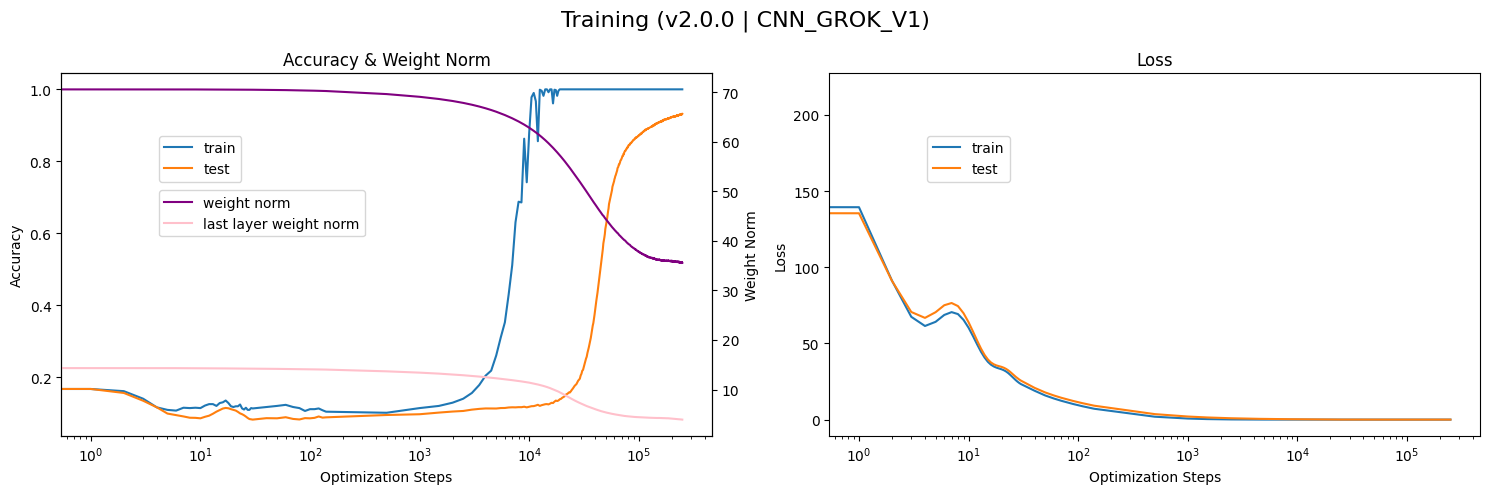

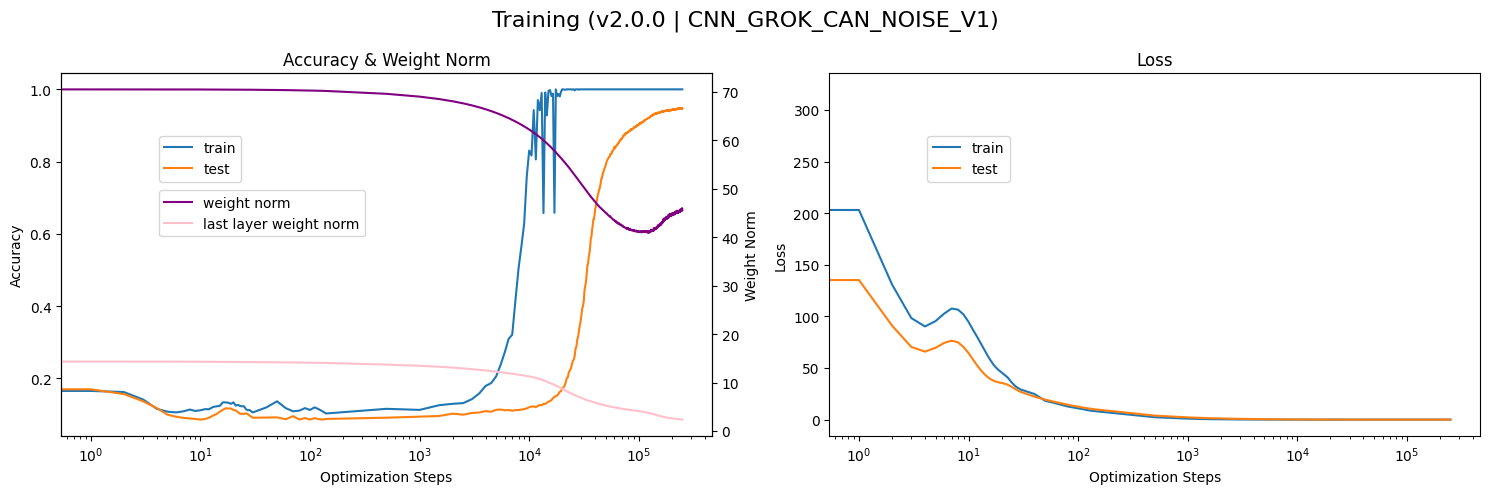

In [7]:
for model, df in dfs.items():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.set_xlabel("Optimization Steps")
    ax1.set_xscale("log")
    ax1.set_ylabel("Accuracy")
    ax1.plot(df["step"], df["train_accuracy"], label="train")
    ax1.plot(df["step"], df["test_accuracy"], label="test")
    ax1.legend(loc=(0.15, 0.7))
    
    ax1_twin = ax1.twinx()
    ax1_twin.set_ylabel("Weight Norm")
    ax1_twin.plot(df["step"], df["norm"], color="purple", label="weight norm")
    ax1_twin.plot(df["step"], df["last_layer_norm"], color="pink", label="last layer weight norm")
    ax1_twin.legend(loc=(0.15, 0.55))
    
    ax1.set_title("Accuracy & Weight Norm")

    ax2.set_xlabel("Optimization Steps")
    ax2.set_xscale("log")
    ax2.set_ylabel("Loss")
    ax2.plot(df["step"], df["train_loss"], label="train")
    ax2.plot(df["step"], df["test_loss"], label="test")
    ax2.legend(loc=(0.15, 0.7))
    ax2.set_title("Loss")

    fig.suptitle("Training ({} | {})".format(RUN_ID, model), fontsize=16)
    plt.tight_layout()
    plt.show()

### Logits

In [8]:
def aggregate_logits_per_step(df: pl.DataFrame) -> pl.DataFrame:
    labels = list(range(NUM_CLASSES))

    correct_logits_exprs = [
        pl.when(pl.col("correct_label") == label).then(pl.col(f"logit_{label}"))
        for label in labels
    ]

    df_with_logits = df.with_columns([
        pl.coalesce(*correct_logits_exprs).alias("correct_logit"),
        pl.sum_horizontal([f"logit_{i}" for i in labels]).alias("sum_all_logits")
    ]).with_columns([
        ((pl.col("sum_all_logits") - pl.col("correct_logit")) / (NUM_CLASSES - 1)).alias("avg_wrong_logit")
    ])

    logits_by_step = (
        df_with_logits
        .group_by("step")
        .agg([
            pl.col("correct_logit").mean().alias("avg_correct_logit"),
            pl.col("correct_logit").std().alias("std_correct_logit"),
            pl.col("avg_wrong_logit").mean().alias("avg_wrong_logit"),
            pl.col("avg_wrong_logit").std().alias("std_wrong_logit"),
            pl.col("correct_logit").count().alias("count")
        ])
        .sort("step")
    )

    return logits_by_step

In [9]:
logit_dfs = {}
for model in MODELS:
    pk.set_params({"model": model.config.name, "step": "*"})

    df_train = pl.read_parquet(pk.TRAIN_LOGITS, glob=True)
    df_test = pl.read_parquet(pk.TEST_LOGITS, glob=True)

    train_logits = aggregate_logits_per_step(df_train)
    test_logits = aggregate_logits_per_step(df_test)
    logit_dfs[model.config.name] = (train_logits, test_logits)

In [10]:
logit_dfs[MODELS[0].config.name][0].head()

step,avg_correct_logit,std_correct_logit,avg_wrong_logit,std_wrong_logit,count
i32,f32,f32,f32,f32,u32
0,0.037939,0.087685,0.048591,0.017505,29997
1,0.195556,0.110583,0.108434,0.019294,29997
2,0.27841,0.162222,0.111634,0.022209,29997
3,0.331059,0.178686,0.093678,0.023059,29997
4,0.379792,0.191617,0.076367,0.02485,29997


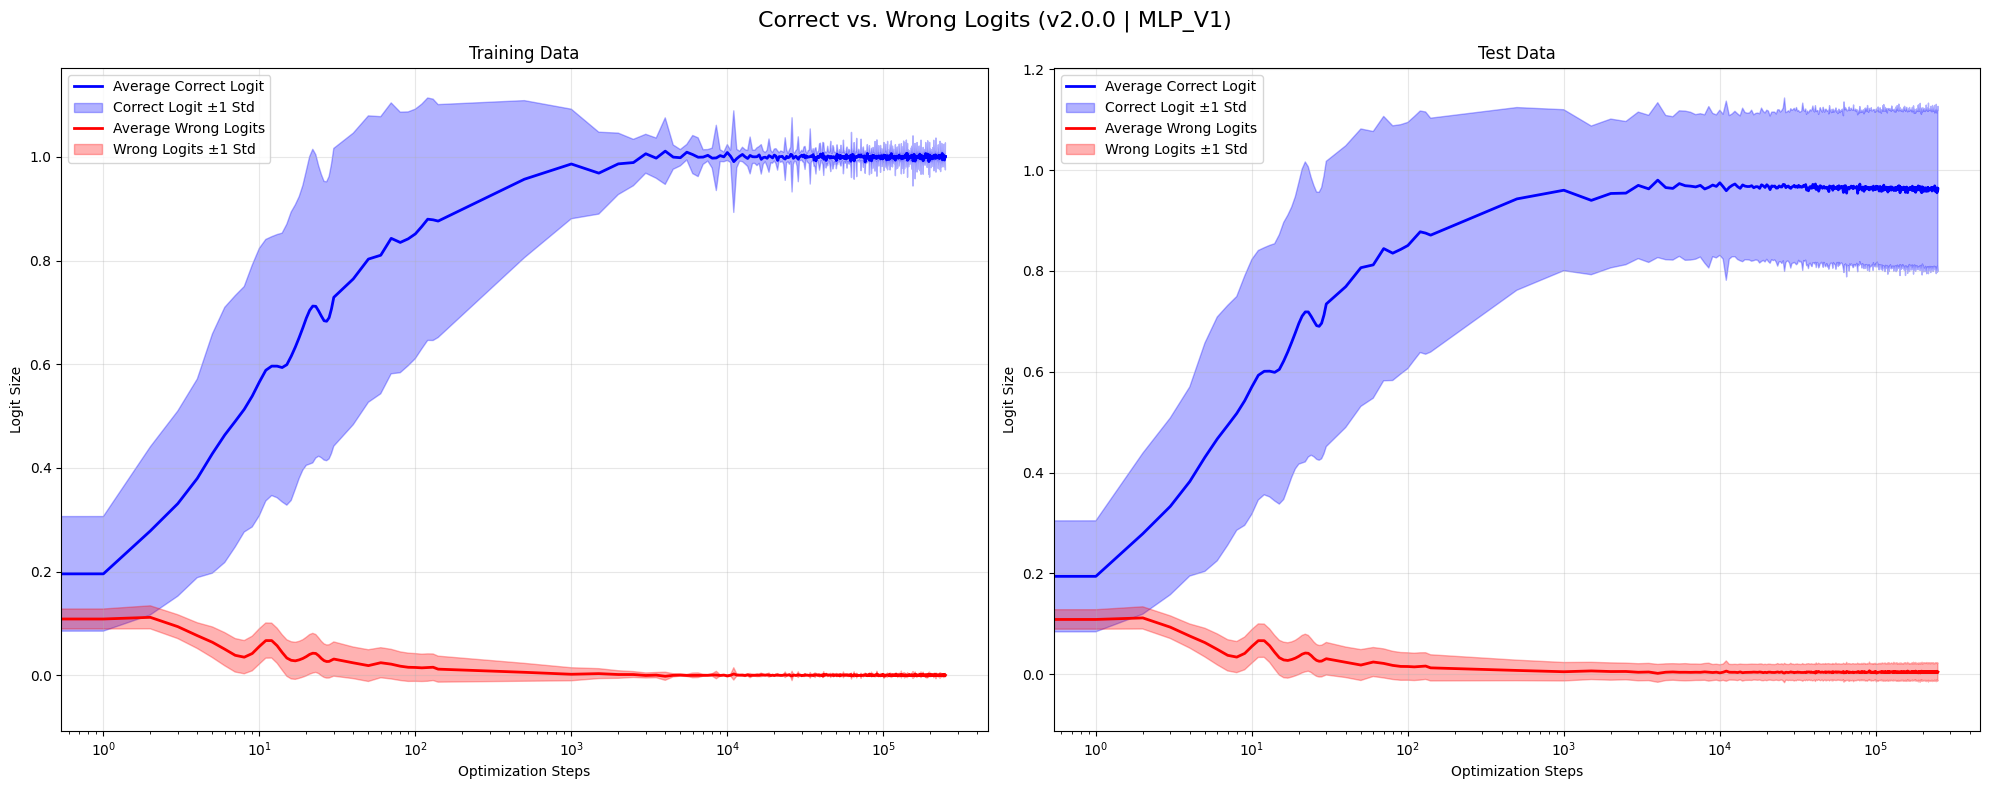

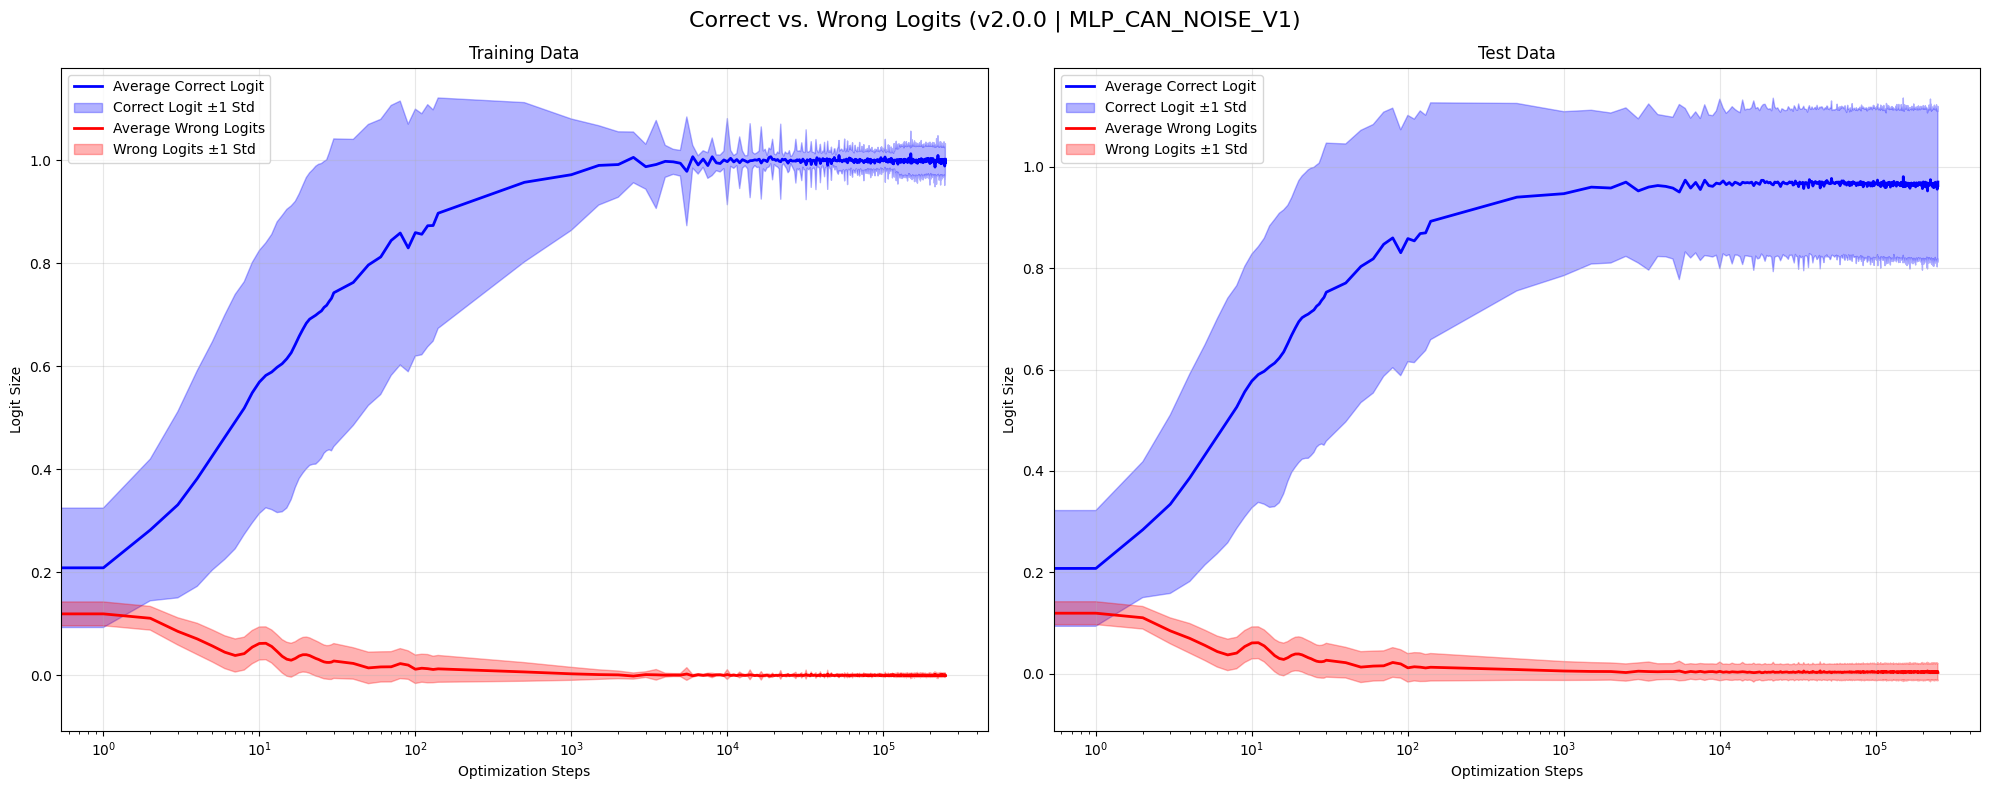

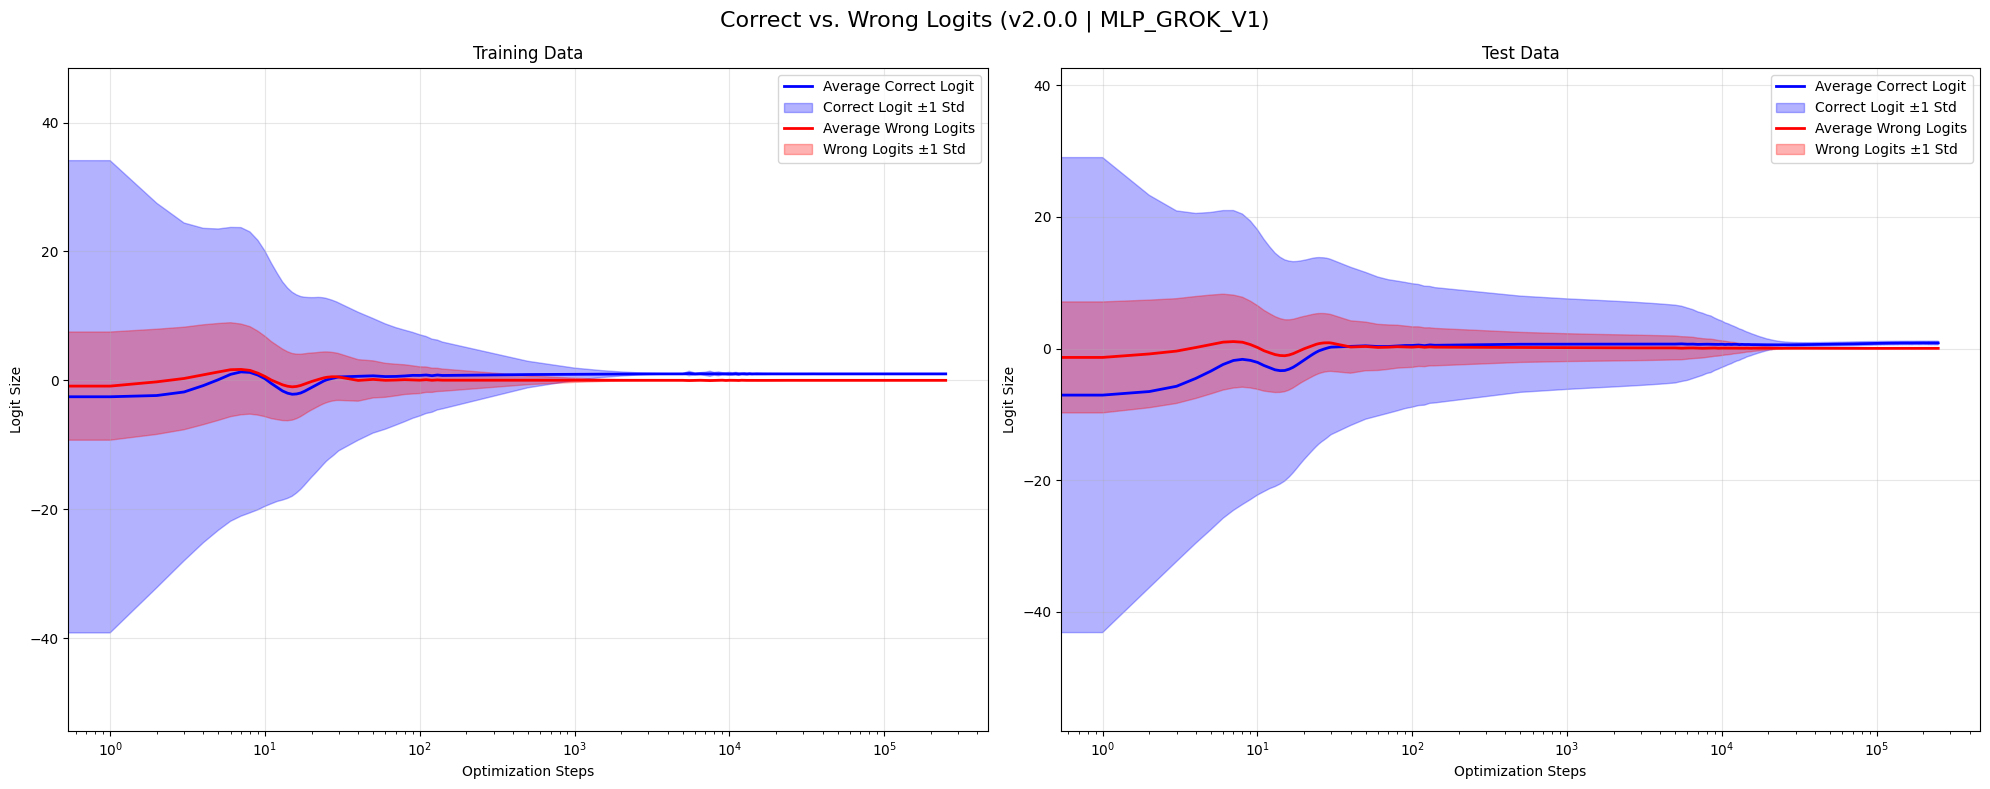

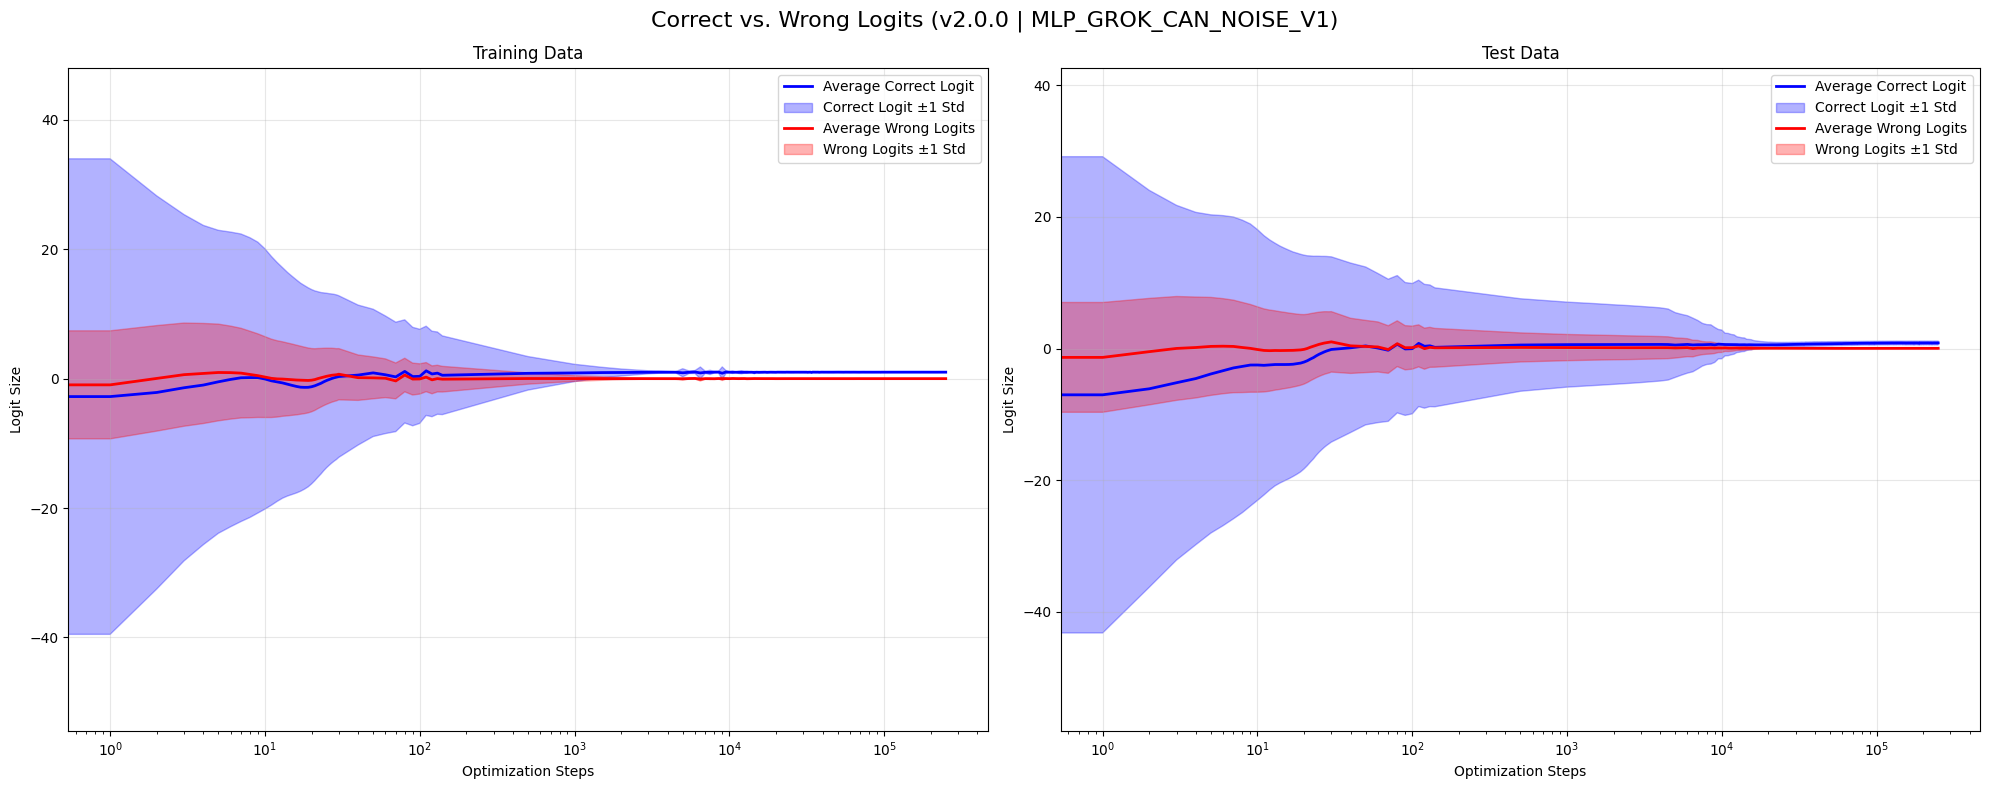

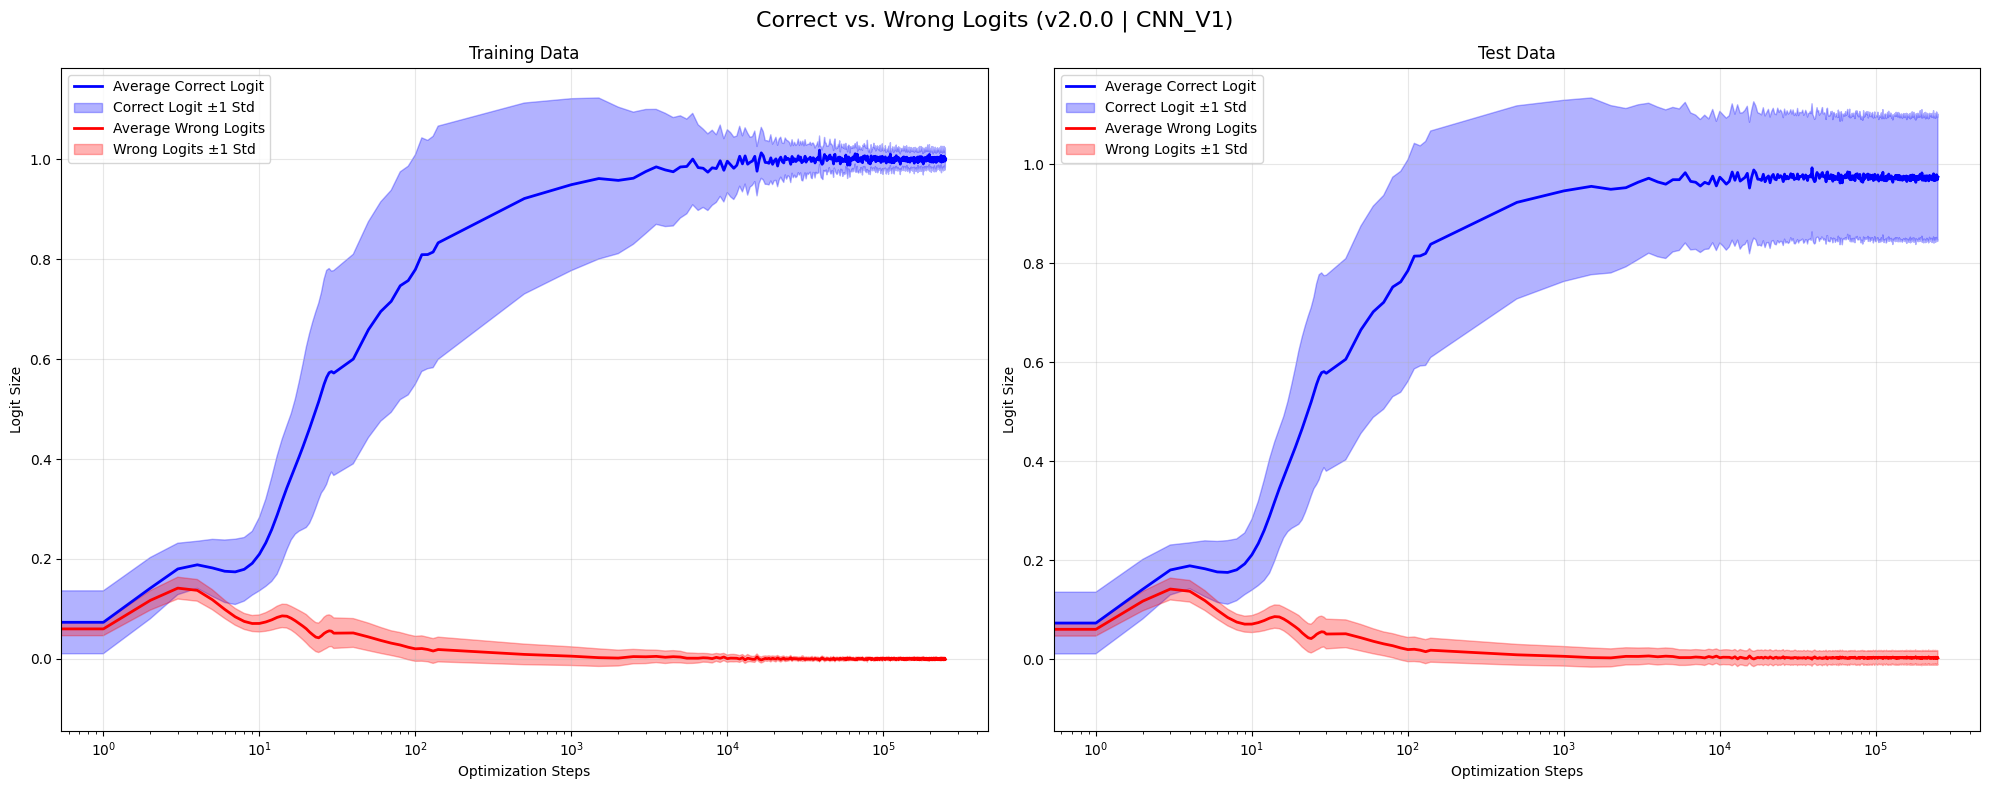

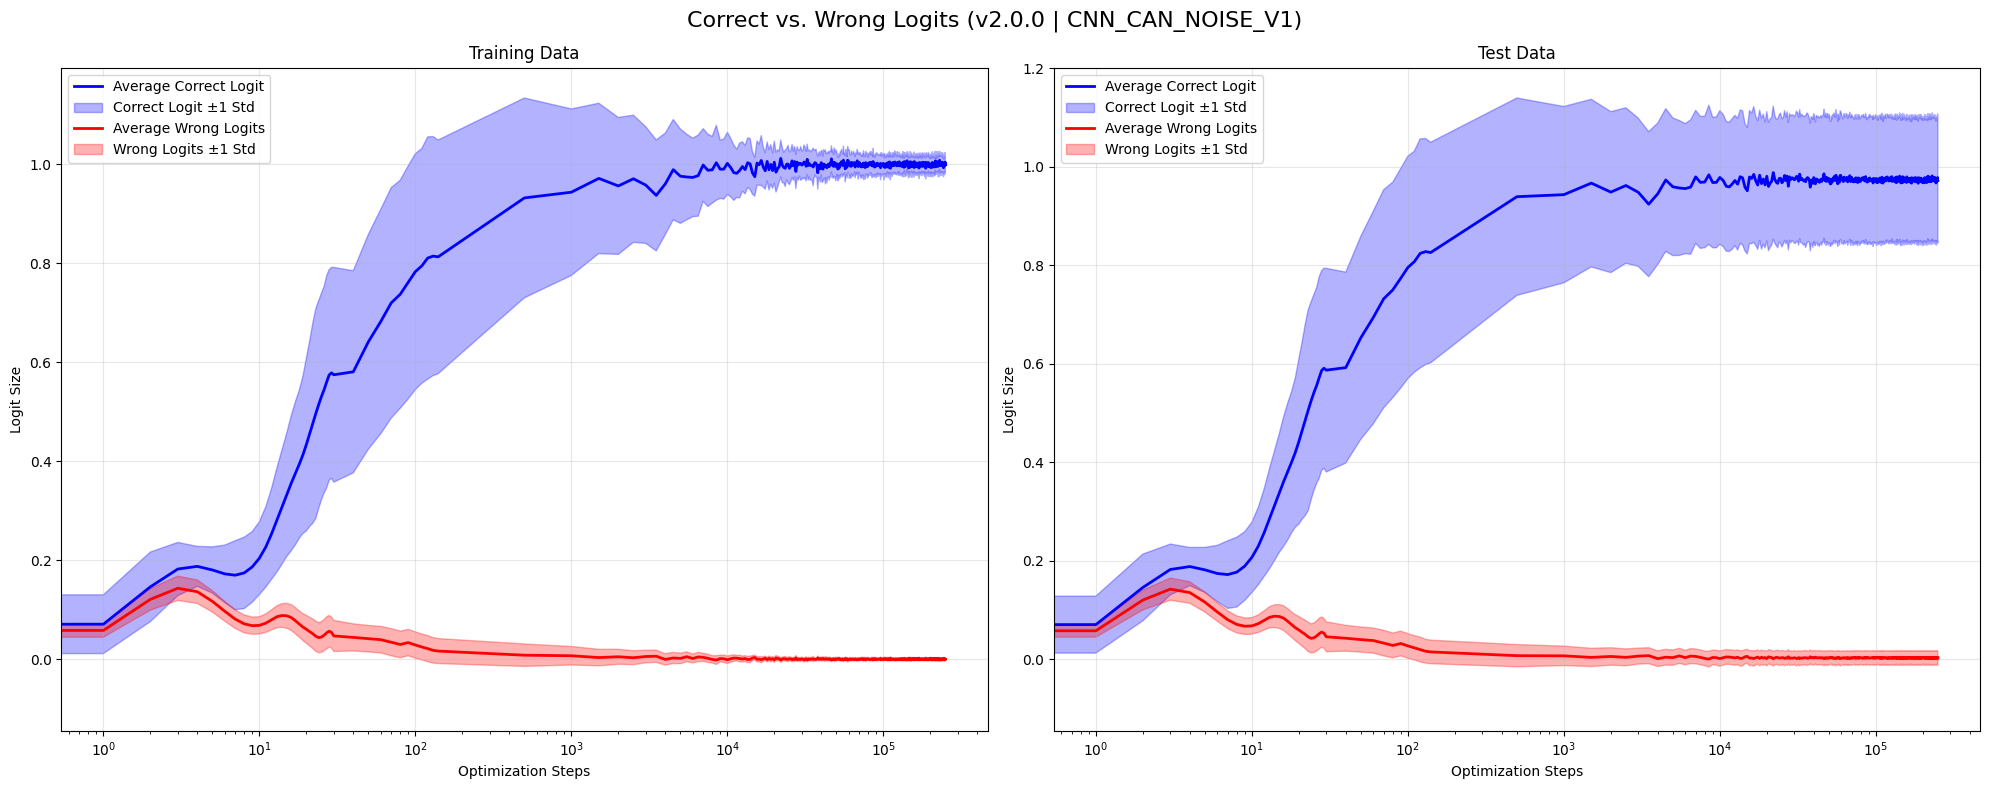

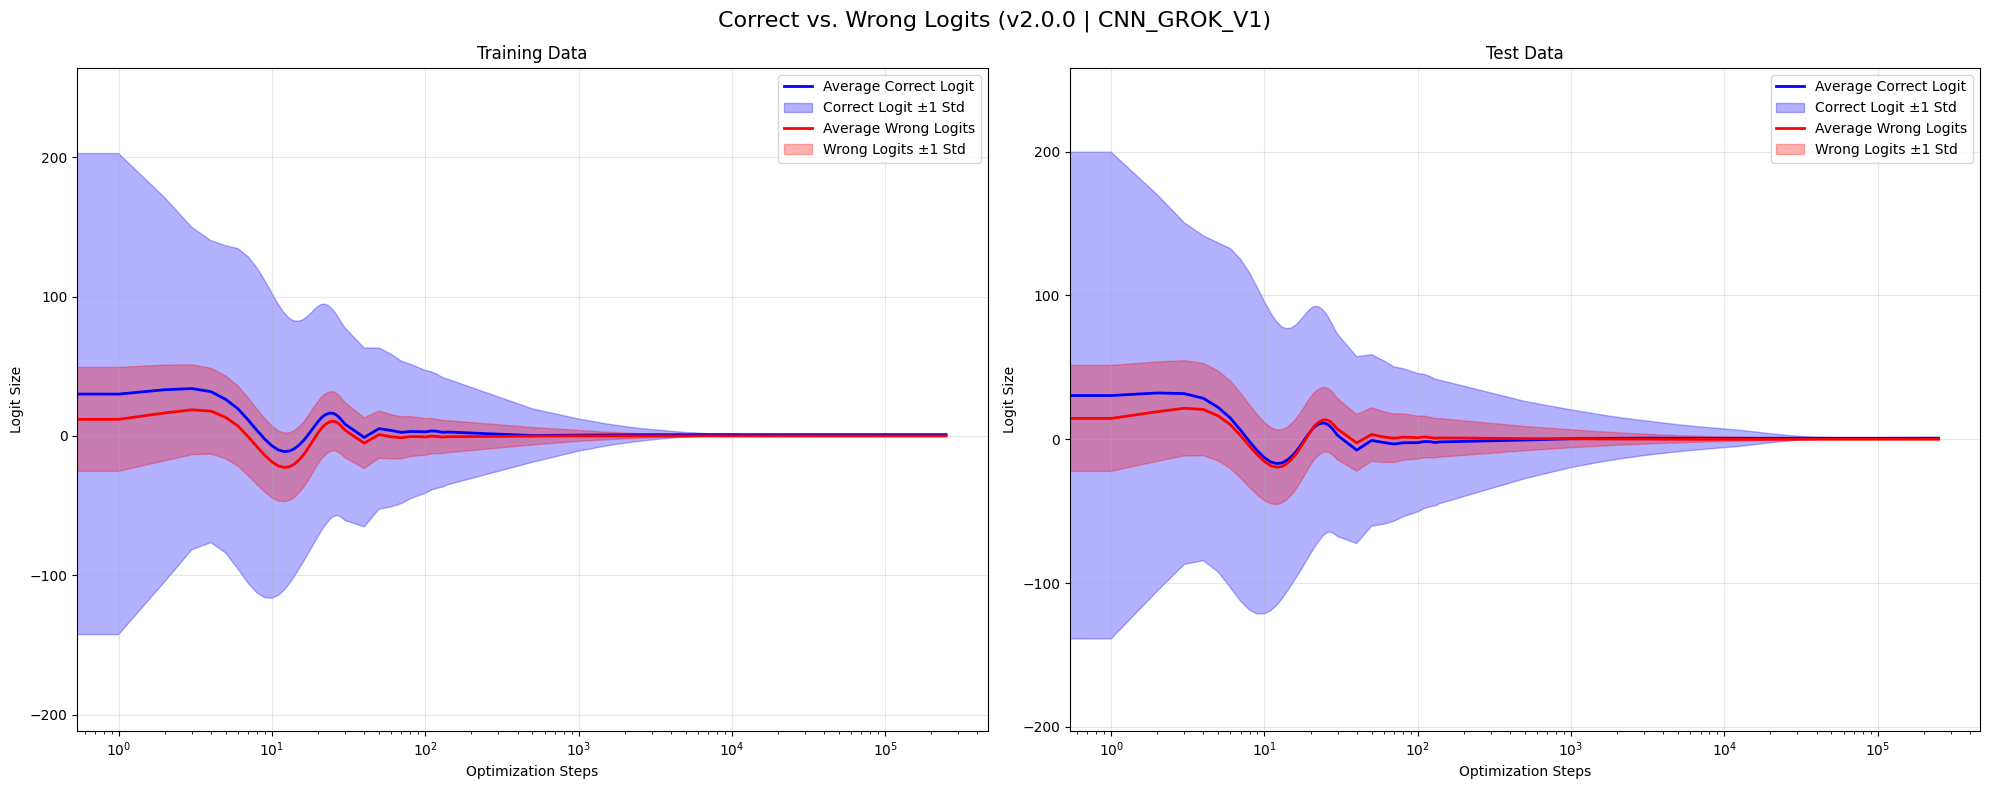

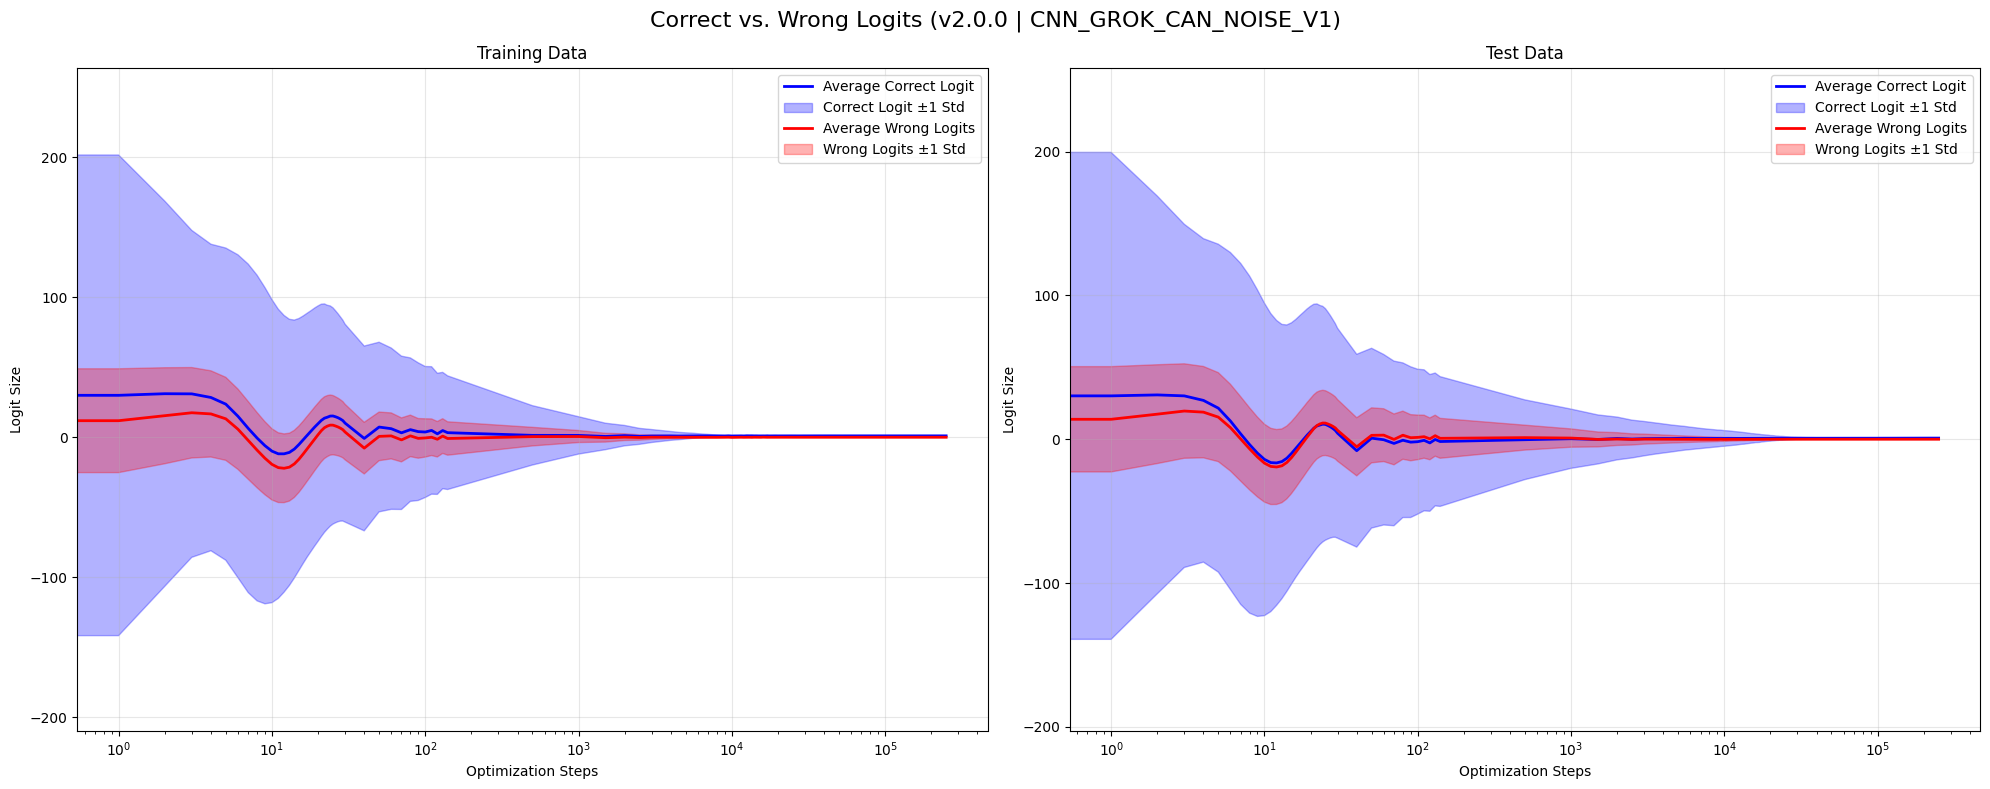

In [11]:
for name, (train_logits, test_logits) in logit_dfs.items():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    steps_train = train_logits["step"].to_numpy()
    avg_correct_train = train_logits["avg_correct_logit"].to_numpy()
    std_correct_train = train_logits["std_correct_logit"].to_numpy()
    avg_wrong_train = train_logits["avg_wrong_logit"].to_numpy()
    std_wrong_train = train_logits["std_wrong_logit"].to_numpy()

    ax1.plot(steps_train, avg_correct_train, "b-", linewidth=2, label="Average Correct Logit")
    ax1.fill_between(steps_train, avg_correct_train - std_correct_train, avg_correct_train + std_correct_train, 
                    alpha=0.3, color="blue", label="Correct Logit ±1 Std")
    ax1.plot(steps_train, avg_wrong_train, "r-", linewidth=2, label="Average Wrong Logits")
    ax1.fill_between(steps_train, avg_wrong_train - std_wrong_train, avg_wrong_train + std_wrong_train, 
                    alpha=0.3, color="red", label="Wrong Logits ±1 Std")
    
    ax1.set_xlabel("Optimization Steps")
    ax1.set_ylabel("Logit Size")
    ax1.set_title("Training Data")
    ax1.set_xscale("log")
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    steps_test = test_logits["step"].to_numpy()
    avg_correct_test = test_logits["avg_correct_logit"].to_numpy()
    std_correct_test = test_logits["std_correct_logit"].to_numpy()
    avg_wrong_test = test_logits["avg_wrong_logit"].to_numpy()
    std_wrong_test = test_logits["std_wrong_logit"].to_numpy()
    
    ax2.plot(steps_test, avg_correct_test, "b-", linewidth=2, label="Average Correct Logit")
    ax2.fill_between(steps_test, avg_correct_test - std_correct_test, avg_correct_test + std_correct_test, 
                    alpha=0.3, color="blue", label="Correct Logit ±1 Std")
    ax2.plot(steps_test, avg_wrong_test, "r-", linewidth=2, label="Average Wrong Logits")
    ax2.fill_between(steps_test, avg_wrong_test - std_wrong_test, avg_wrong_test + std_wrong_test, 
                    alpha=0.3, color="red", label="Wrong Logits ±1 Std")
    
    ax2.set_xlabel("Optimization Steps")
    ax2.set_ylabel("Logit Size")
    ax2.set_title("Test Data")
    ax2.set_xscale("log")
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    fig.suptitle("Correct vs. Wrong Logits ({} | {})".format(RUN_ID, name), fontsize=16)
    plt.tight_layout()
    plt.show()

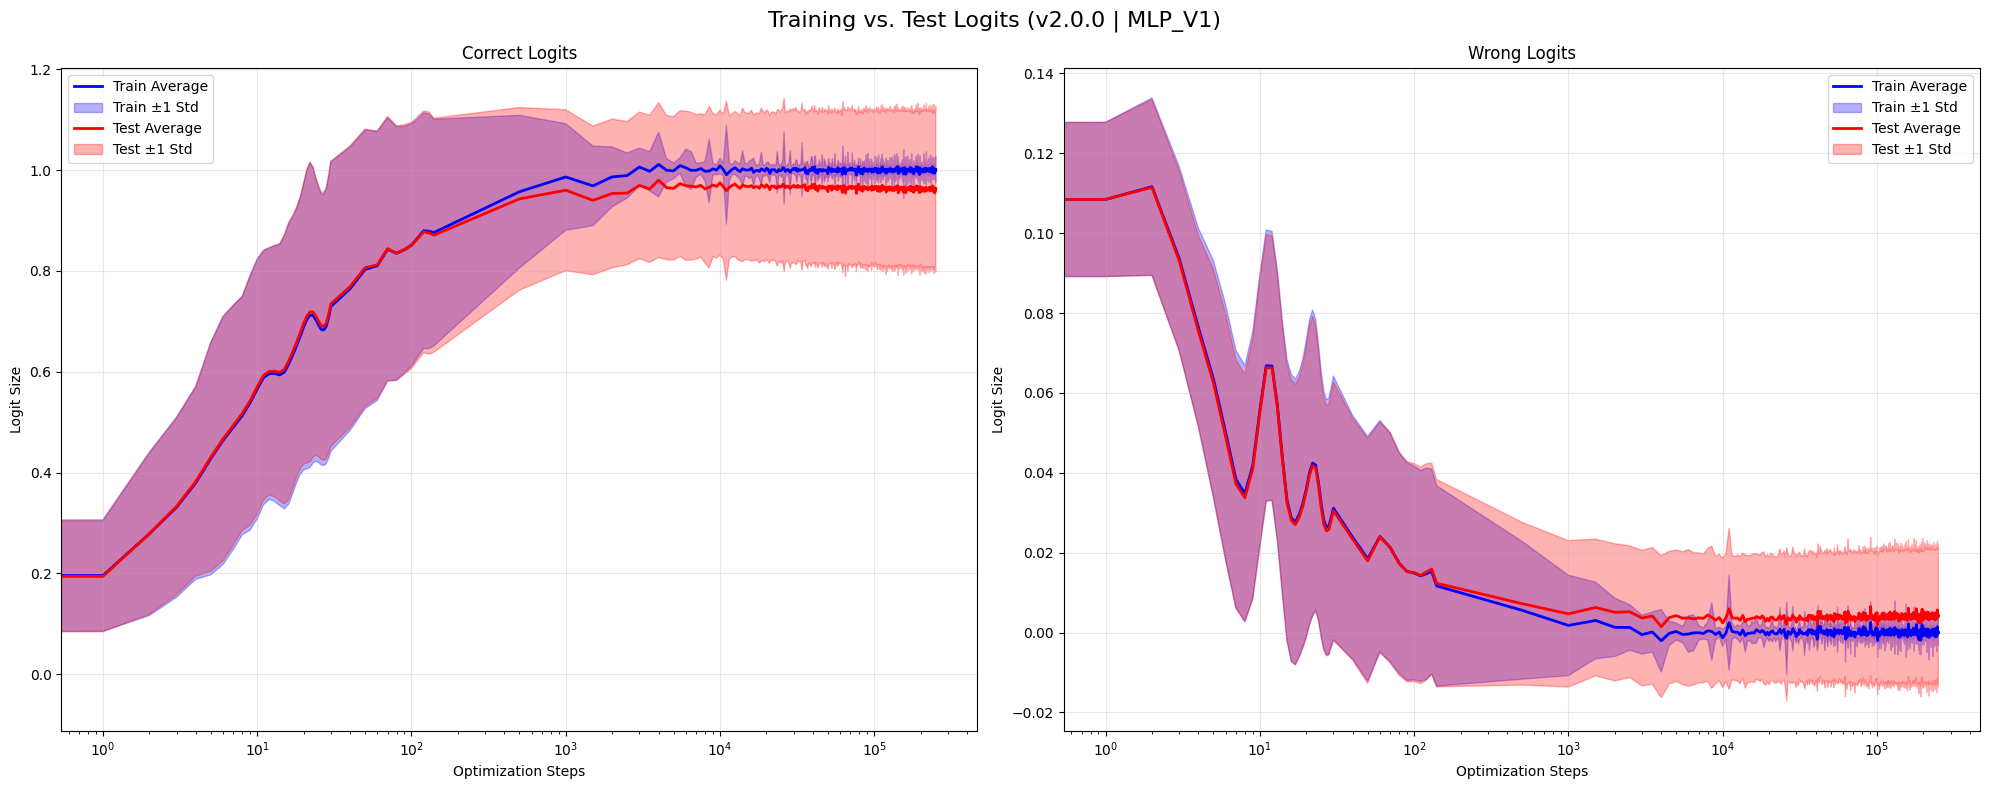

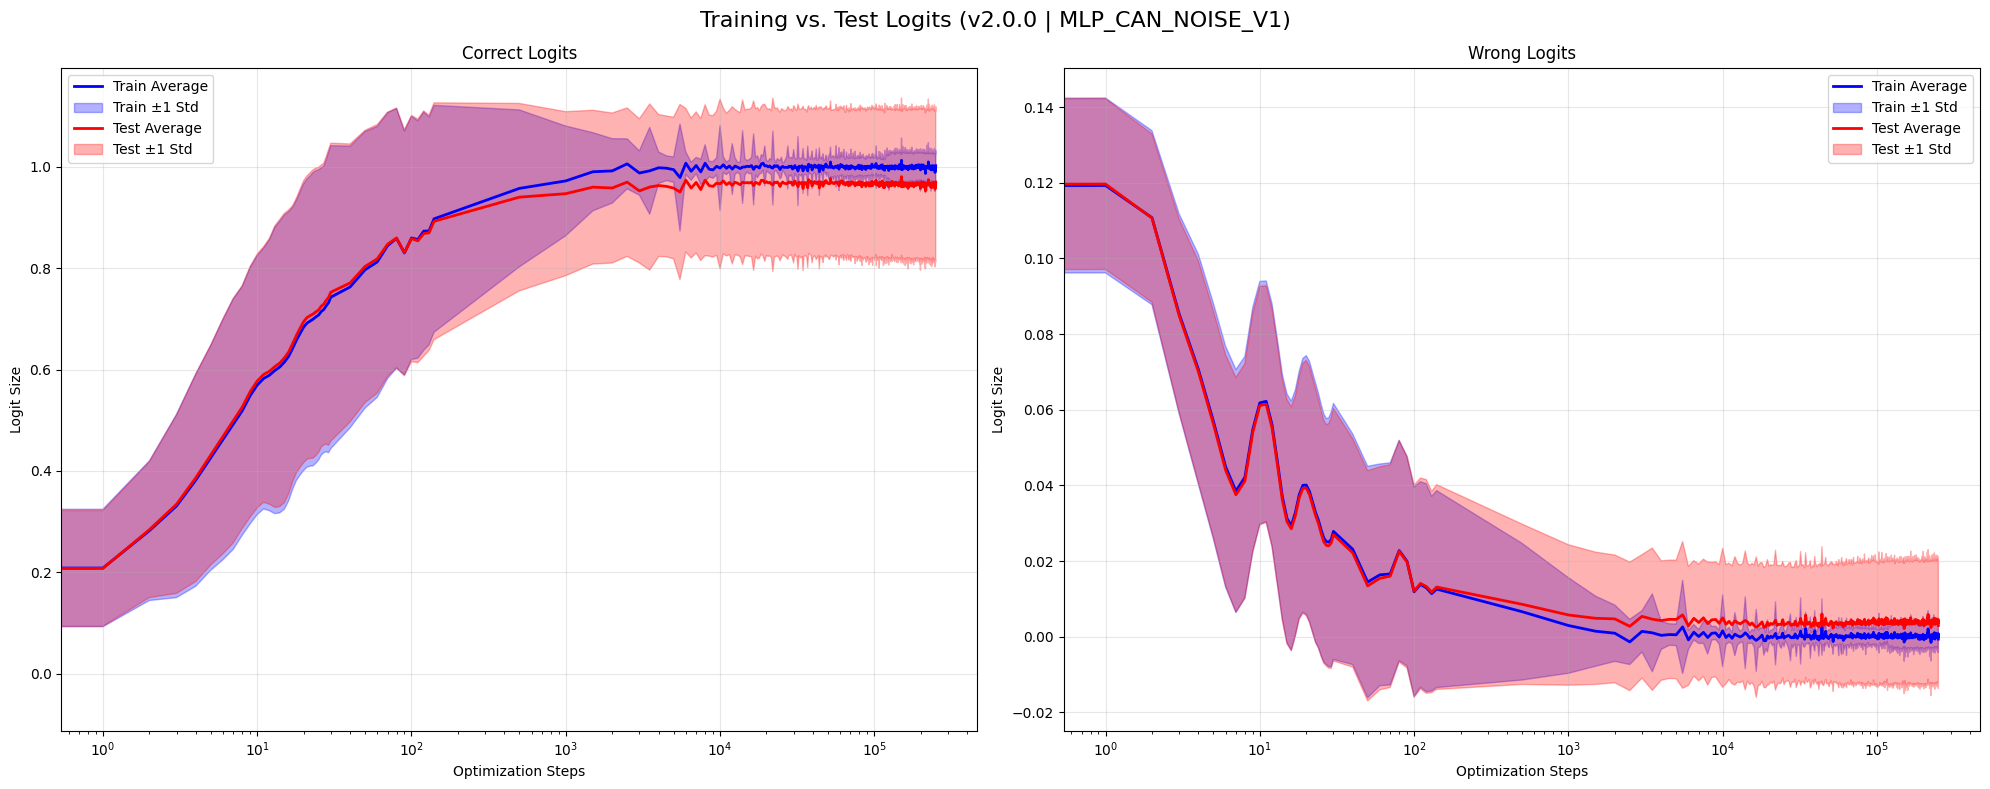

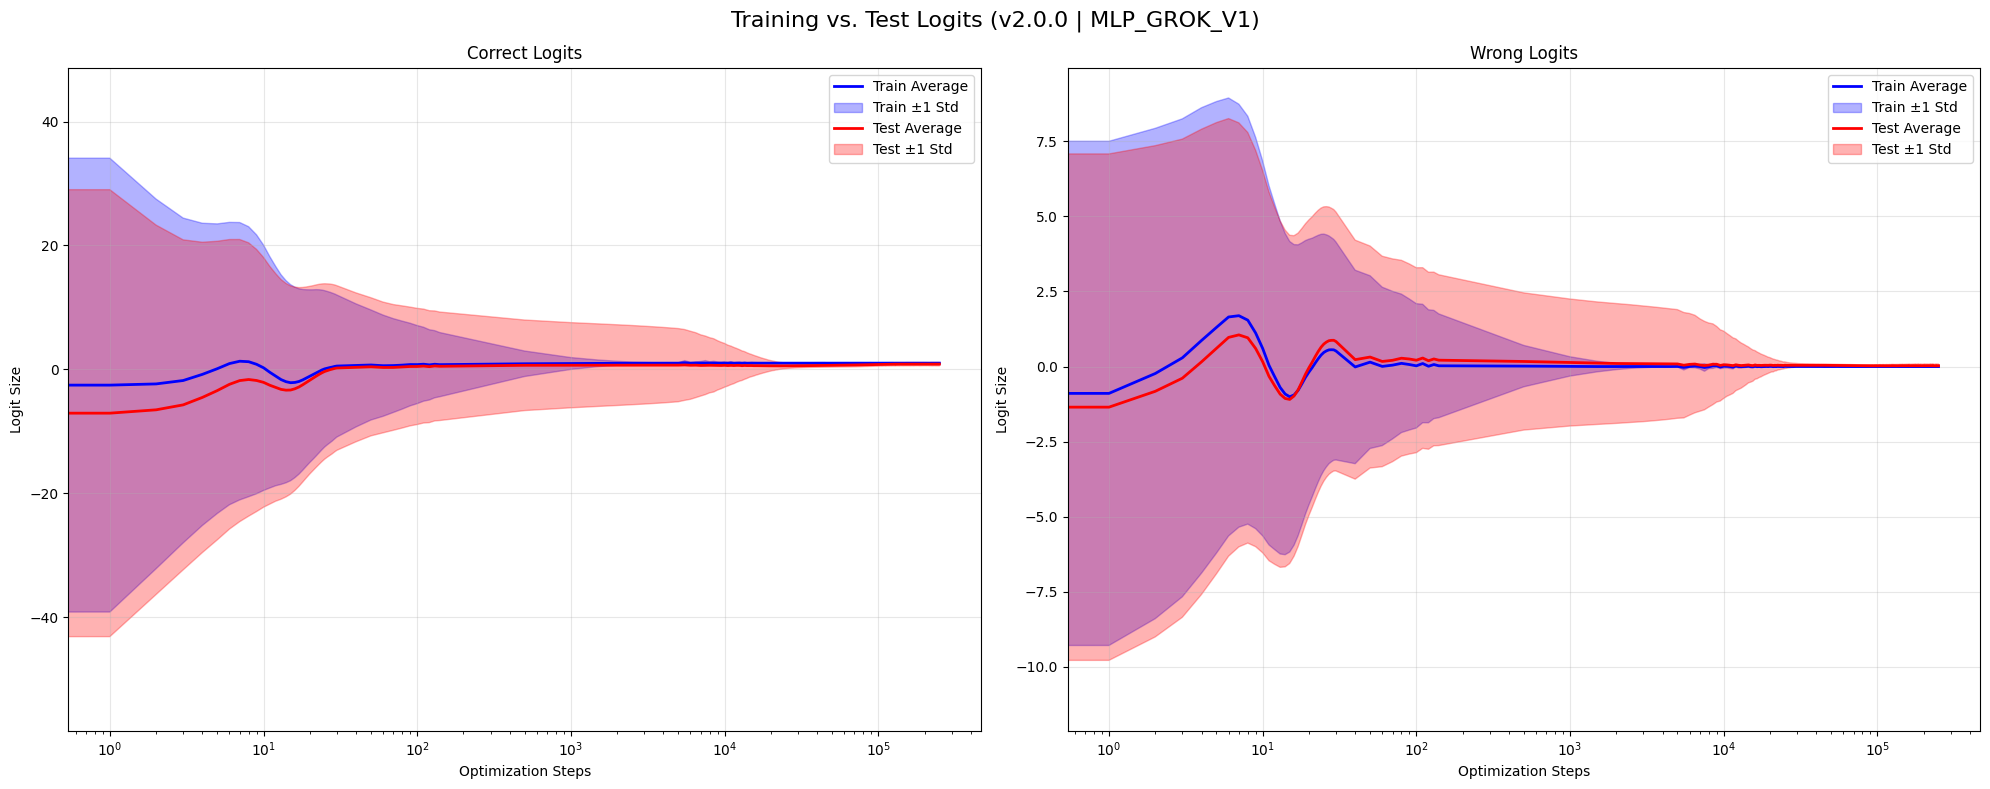

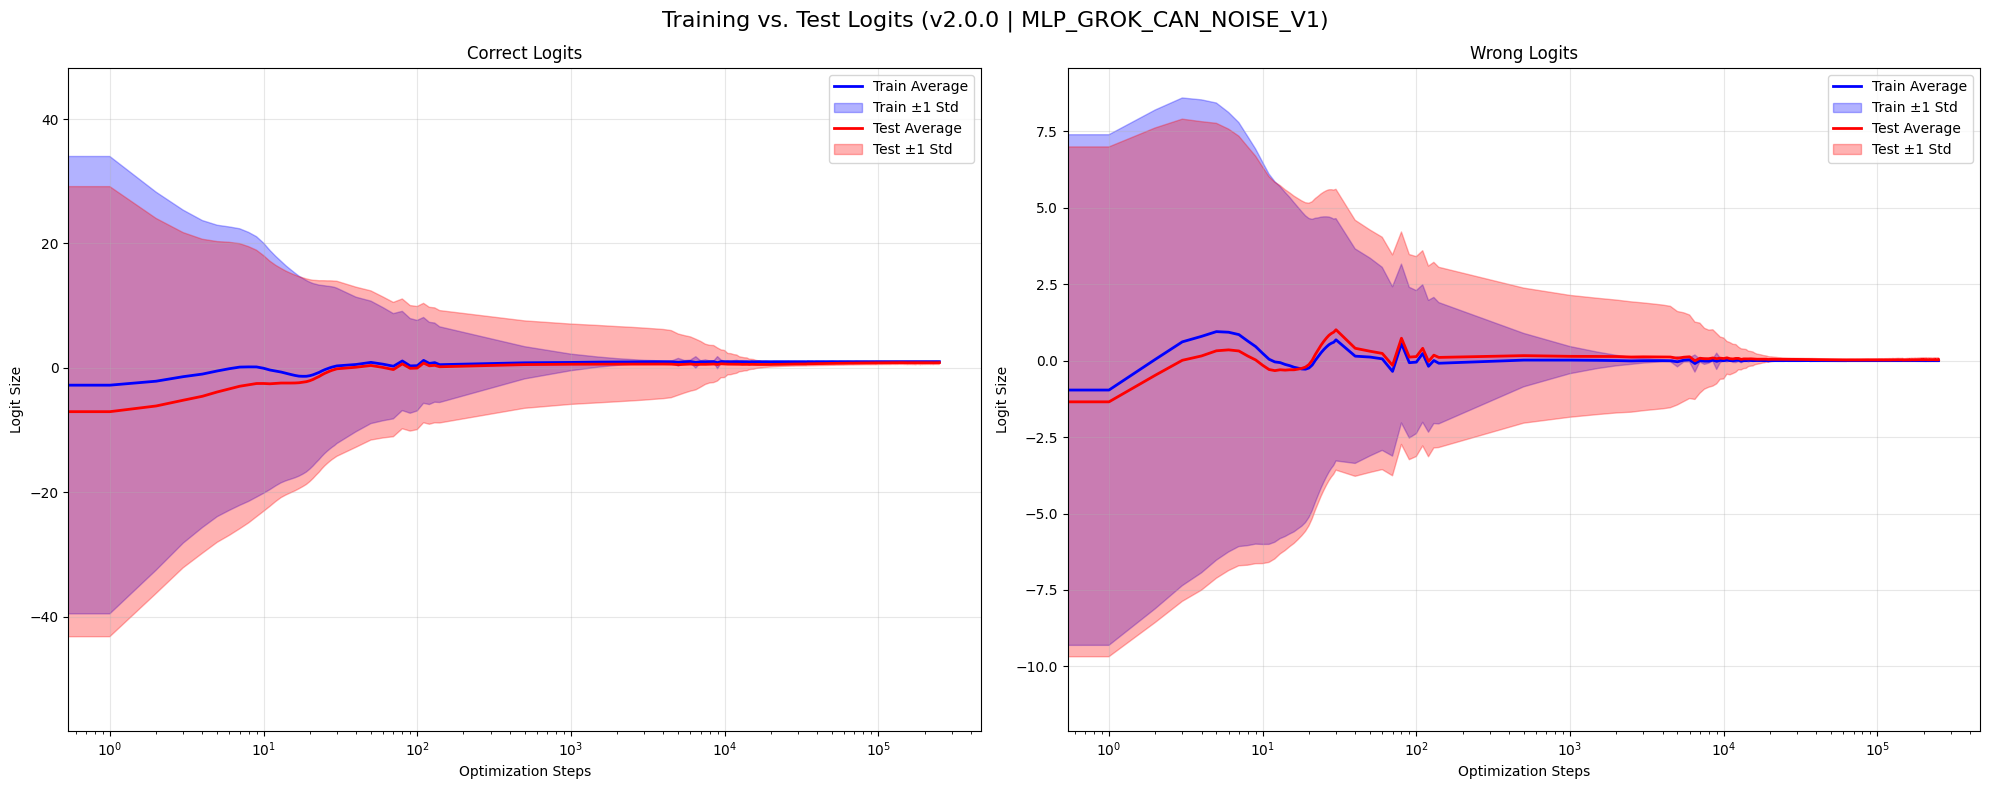

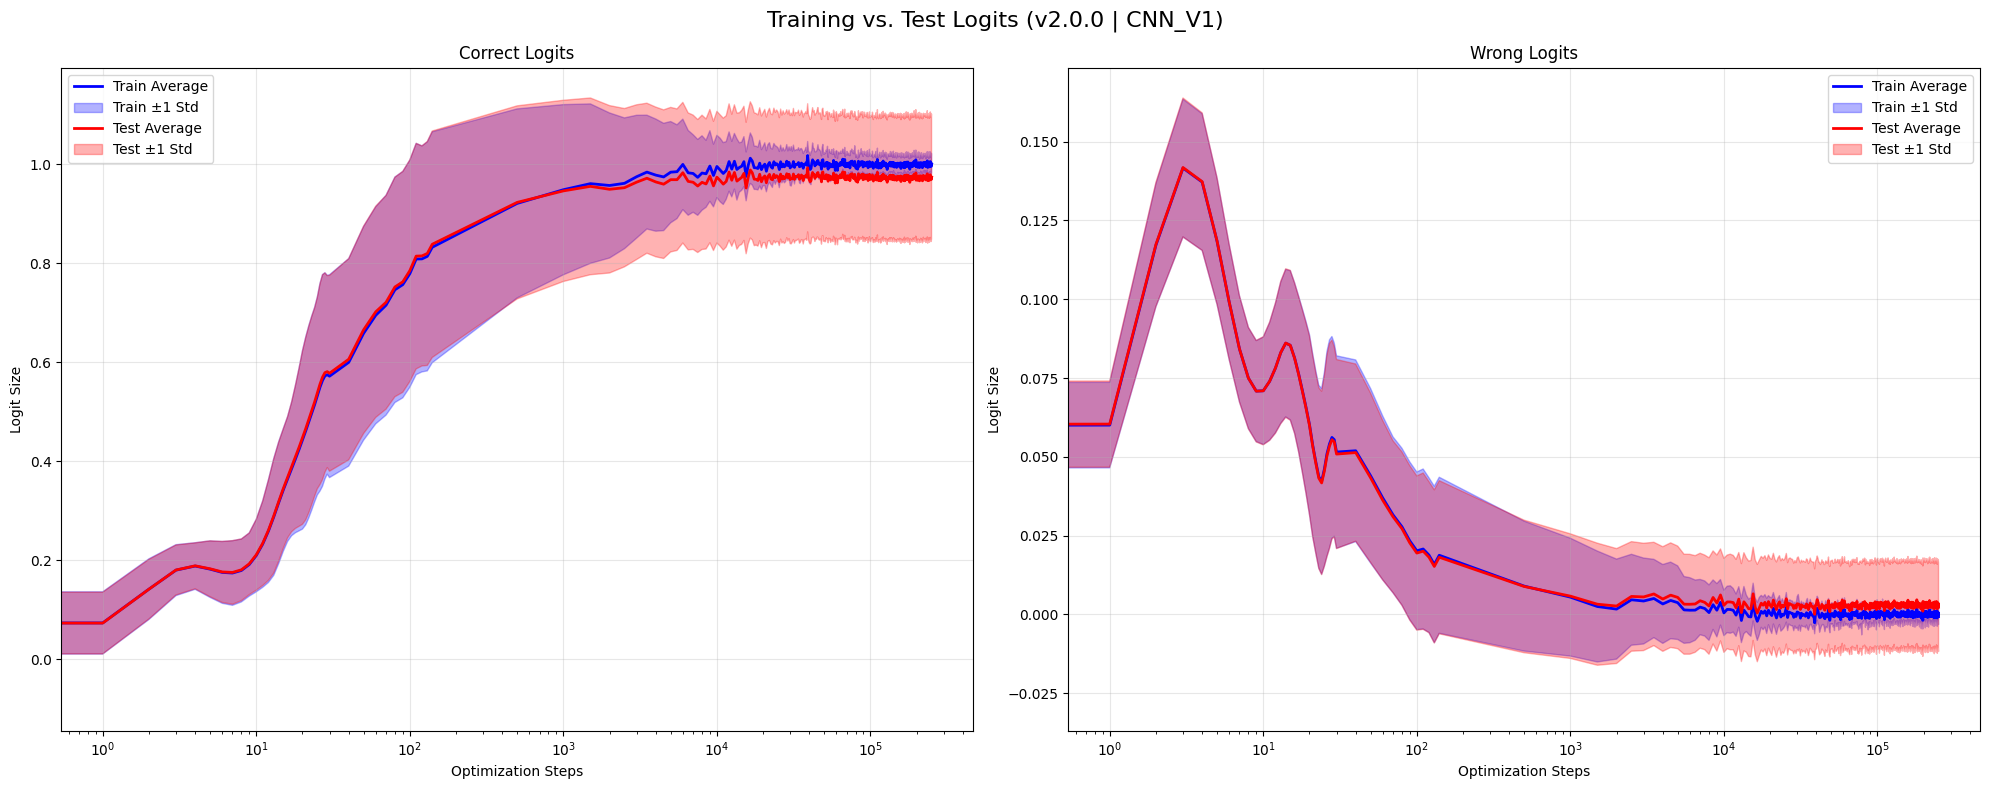

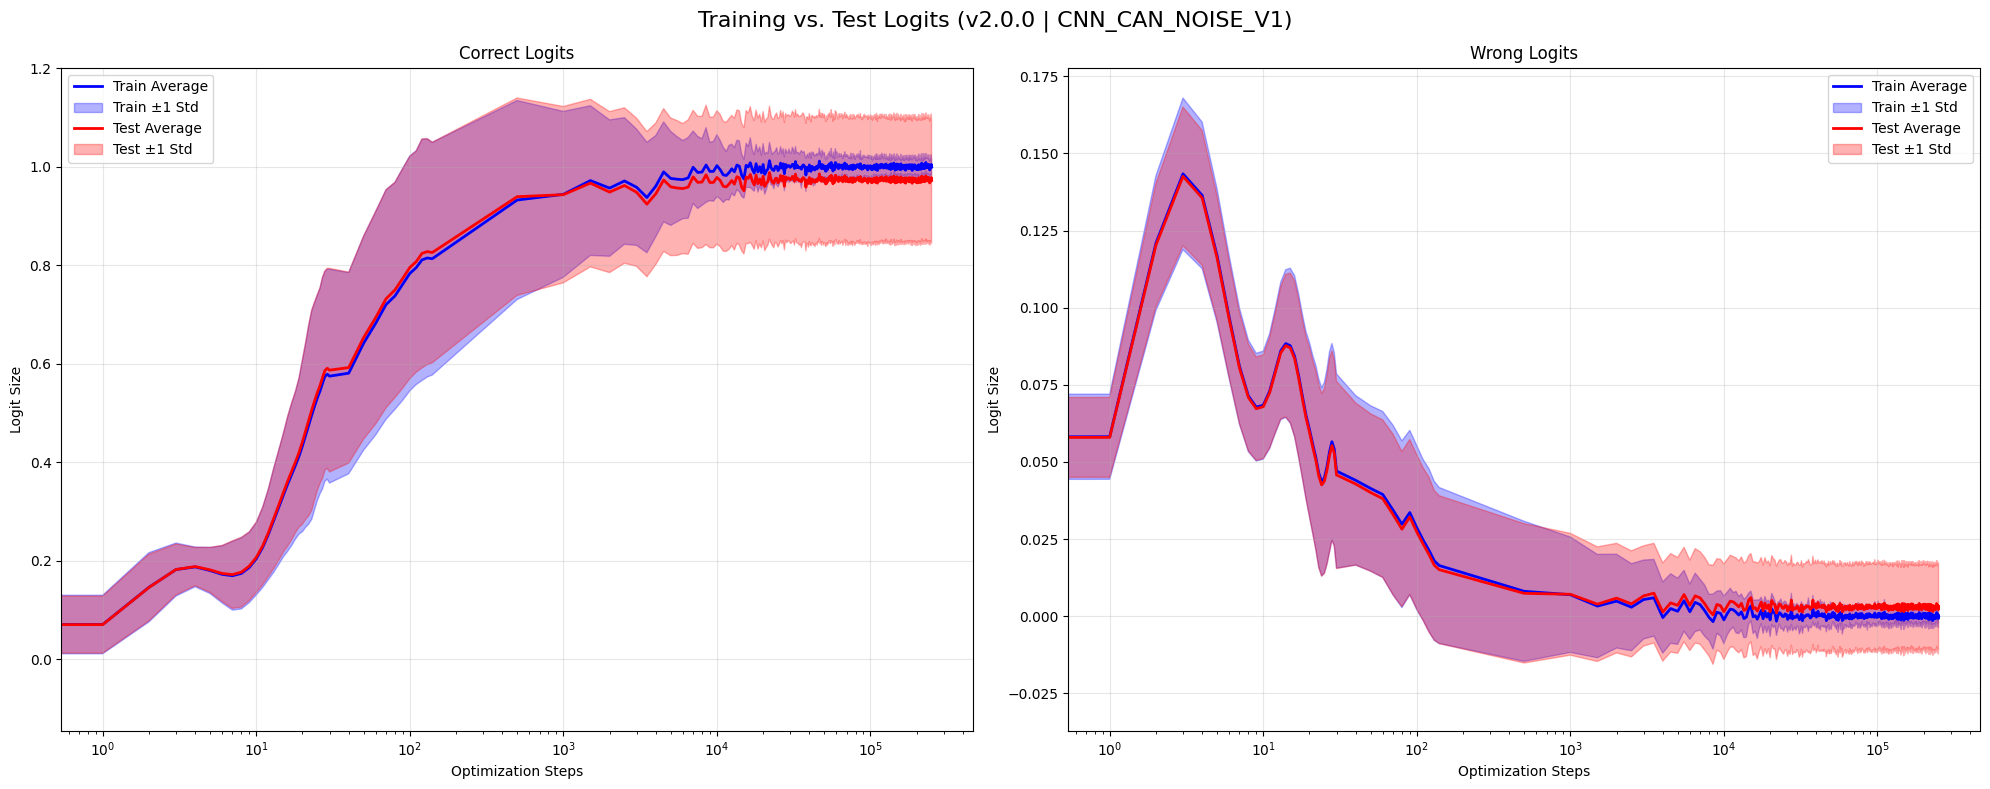

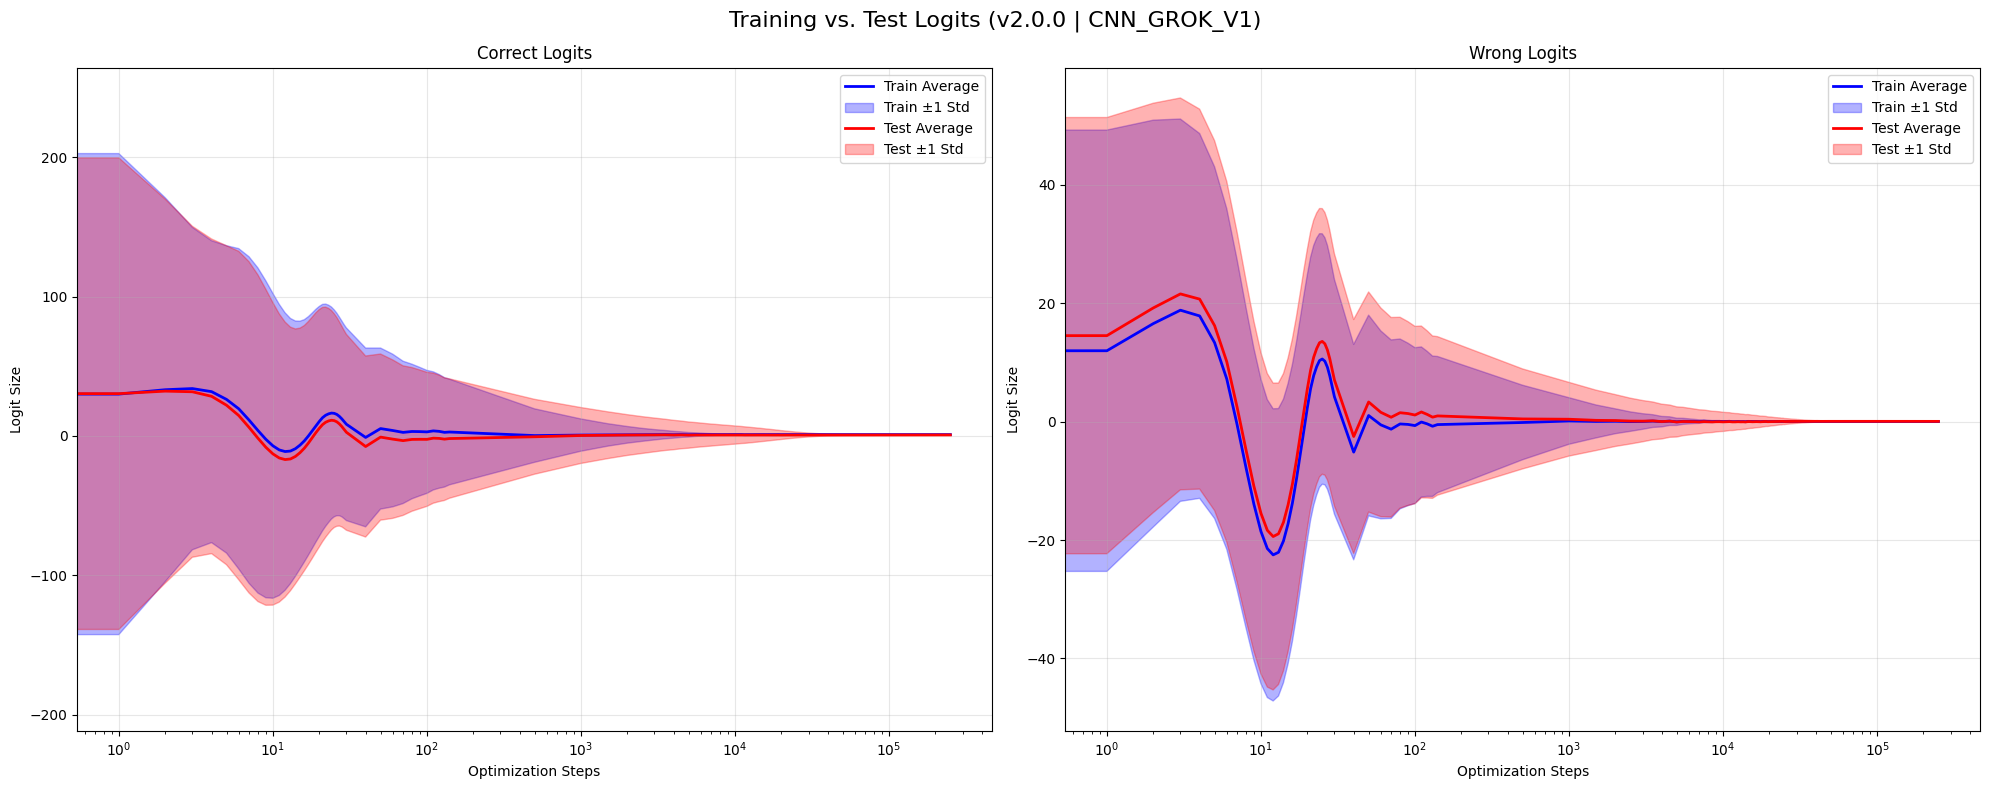

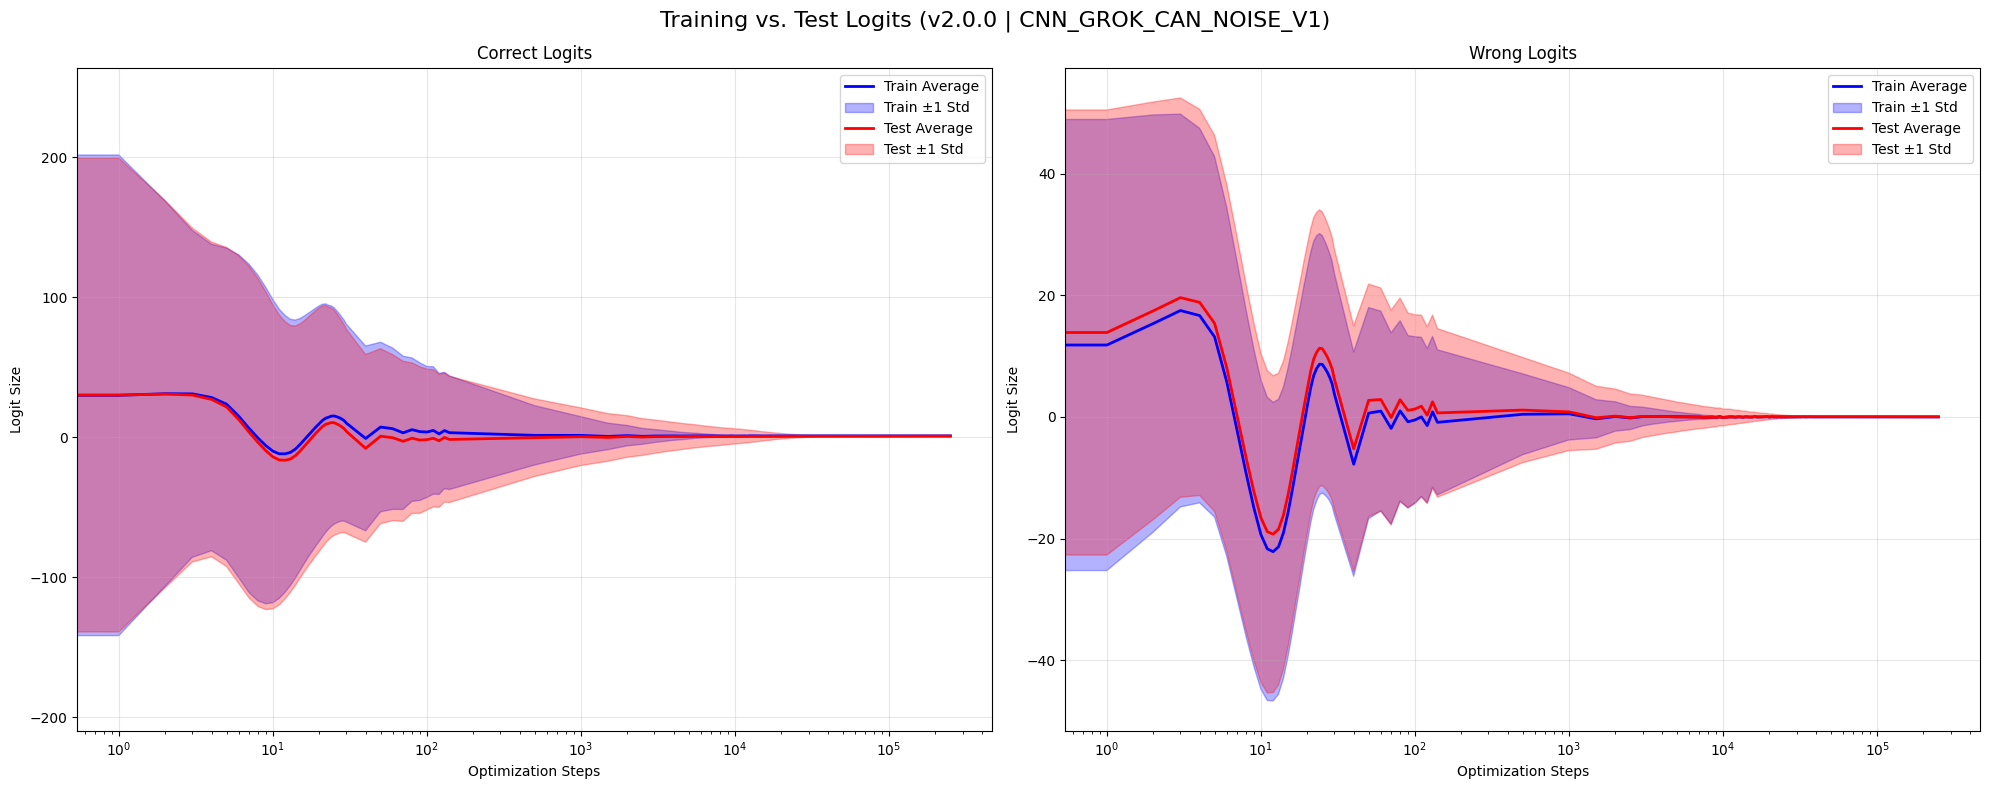

In [12]:
for name, (train_logits, test_logits) in logit_dfs.items():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    steps = train_logits["step"].to_numpy()
    # Correct logits
    avg_correct_train = train_logits["avg_correct_logit"].to_numpy()
    std_correct_train = train_logits["std_correct_logit"].to_numpy()
    avg_correct_test = test_logits["avg_correct_logit"].to_numpy()
    std_correct_test = test_logits["std_correct_logit"].to_numpy()

    ax1.plot(steps, avg_correct_train, "b-", linewidth=2, label="Train Average")
    ax1.fill_between(steps, avg_correct_train - std_correct_train, avg_correct_train + std_correct_train, 
                    alpha=0.3, color="blue", label="Train ±1 Std")
    ax1.plot(steps, avg_correct_test, "r-", linewidth=2, label="Test Average")
    ax1.fill_between(steps, avg_correct_test - std_correct_test, avg_correct_test + std_correct_test, 
                    alpha=0.3, color="red", label="Test ±1 Std")
    
    ax1.set_xlabel("Optimization Steps")
    ax1.set_ylabel("Logit Size")
    ax1.set_title("Correct Logits")
    ax1.set_xscale("log")
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Wrong logits
    avg_wrong_train = train_logits["avg_wrong_logit"].to_numpy()
    std_wrong_train = train_logits["std_wrong_logit"].to_numpy()
    avg_wrong_test = test_logits["avg_wrong_logit"].to_numpy()
    std_wrong_test = test_logits["std_wrong_logit"].to_numpy()
    
    ax2.plot(steps, avg_wrong_train, "b-", linewidth=2, label="Train Average")
    ax2.fill_between(steps, avg_wrong_train - std_wrong_train, avg_wrong_train + std_wrong_train, 
                    alpha=0.3, color="blue", label="Train ±1 Std")
    ax2.plot(steps, avg_wrong_test, "r-", linewidth=2, label="Test Average")
    ax2.fill_between(steps, avg_wrong_test - std_wrong_test, avg_wrong_test + std_wrong_test, 
                    alpha=0.3, color="red", label="Test ±1 Std")
    
    ax2.set_xlabel("Optimization Steps")
    ax2.set_ylabel("Logit Size")
    ax2.set_title("Wrong Logits")
    ax2.set_xscale("log")
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    fig.suptitle("Training vs. Test Logits ({} | {})".format(RUN_ID, name), fontsize=16)
    plt.tight_layout()
    plt.show()

In [14]:
def process_single_step_logits(df: pl.DataFrame) -> pl.DataFrame:
    labels = df["correct_label"].unique().sort().to_list() 
    expressions = [
        pl.when(pl.col("correct_label") == label).then(pl.col(f"logit_{label}"))
        for label in labels
    ]
    return df.with_columns(
        pl.coalesce(*expressions).alias("correct_logit")
    )

single_step_logit_dfs = {}
for model in MODELS:
    pk.set_params({"model": model.config.name, "step": 100_000})

    df_train = pl.read_parquet(pk.TRAIN_LOGITS)
    df_test = pl.read_parquet(pk.TEST_LOGITS)

    single_step_logit_dfs[model.config.name] = (process_single_step_logits(df_train), process_single_step_logits(df_test))

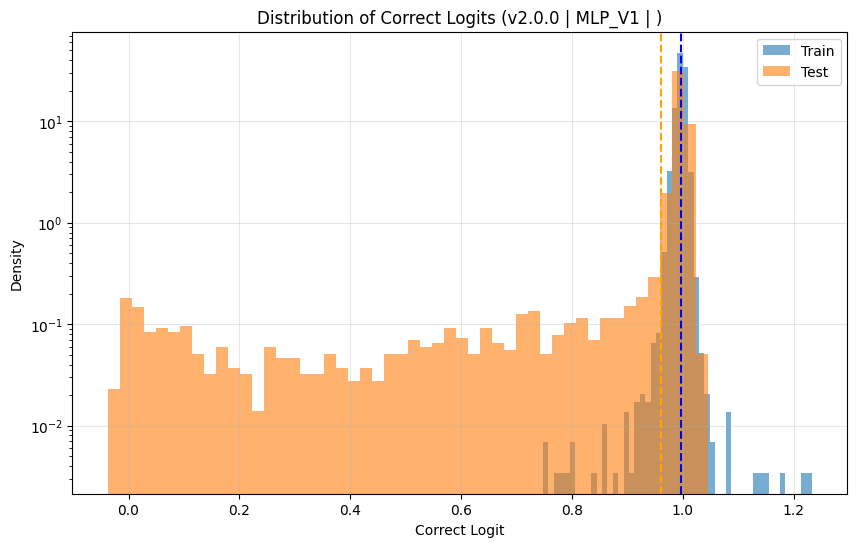

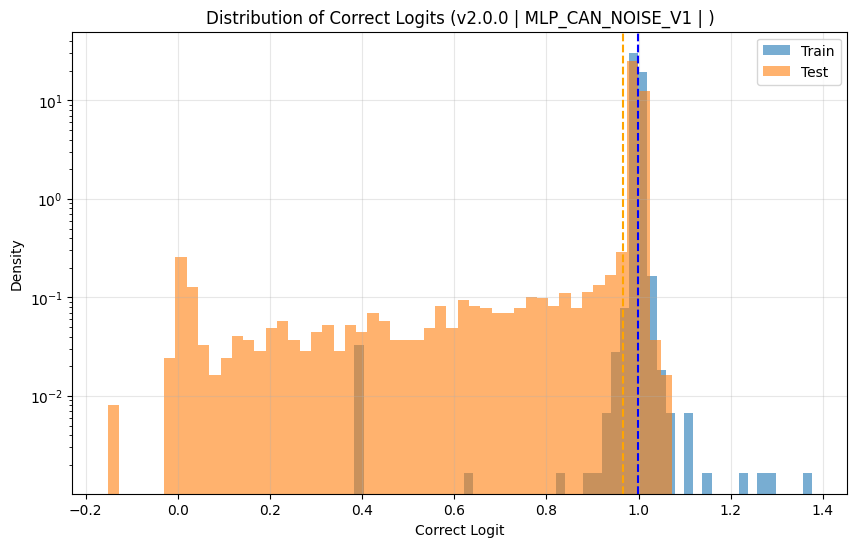

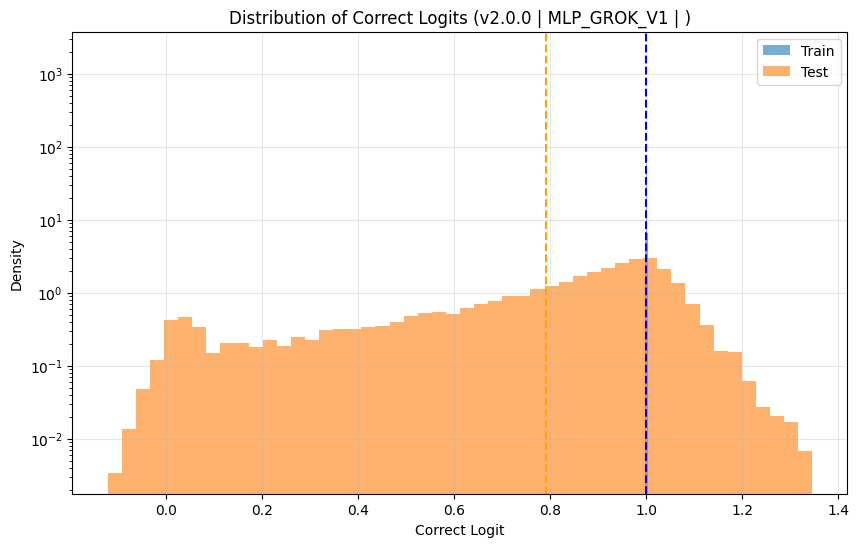

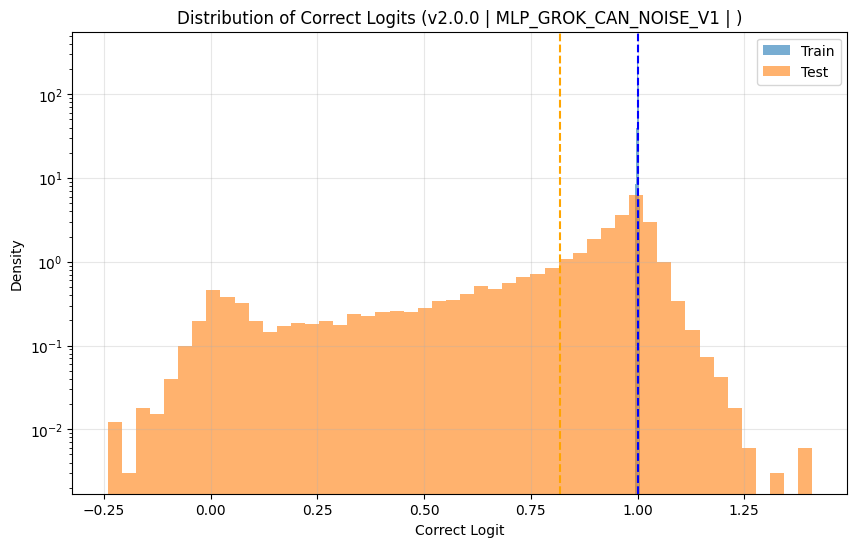

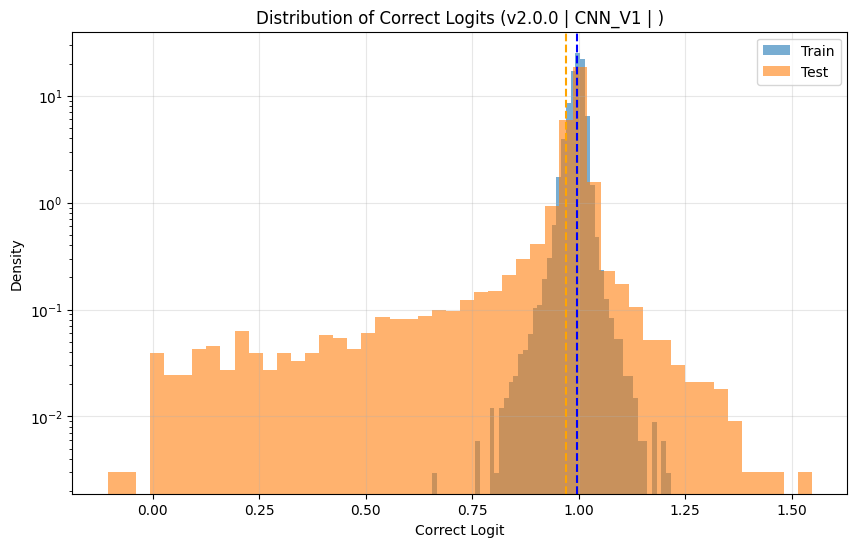

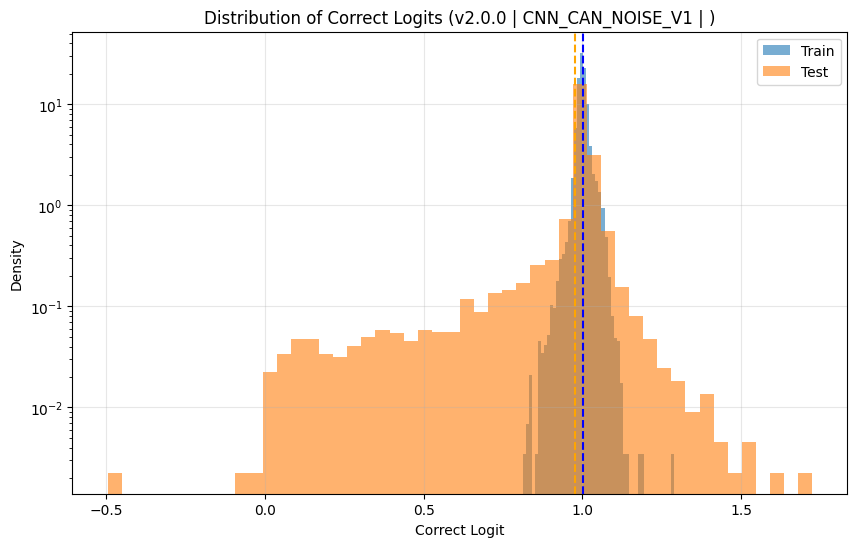

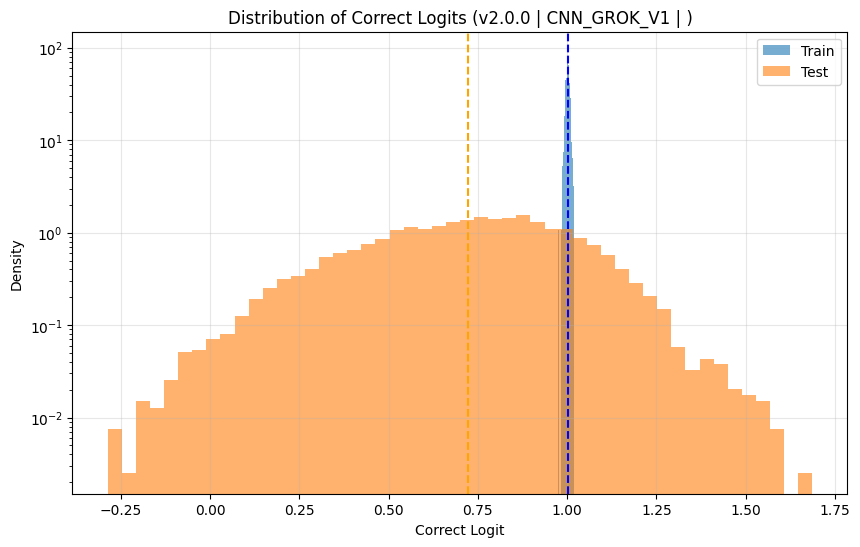

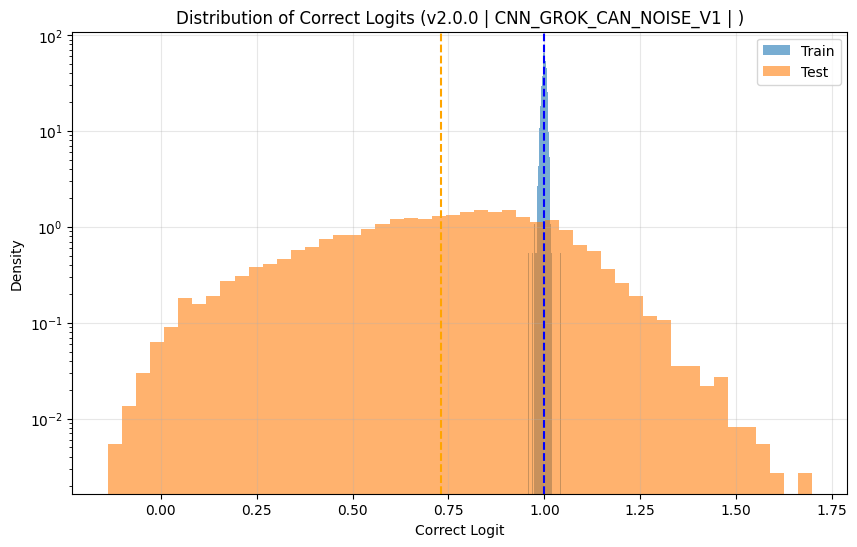

In [15]:
for name, (train_logits, test_logits) in single_step_logit_dfs.items():
    plt.figure(figsize=(10, 6))
    plt.hist(train_logits["correct_logit"].to_numpy(), bins=50, alpha=0.6, label="Train", density=True)
    plt.hist(test_logits["correct_logit"].to_numpy(), bins=50, alpha=0.6, label="Test", density=True)
    plt.xlabel("Correct Logit")
    plt.ylabel("Density")
    plt.yscale("log")
    plt.title("Distribution of Correct Logits ({} | {} | )".format(RUN_ID, name))
    plt.legend()
    plt.axvline(x=train_logits["correct_logit"].mean(), color="blue", linestyle="--", label="Train Mean")
    plt.axvline(x=test_logits["correct_logit"].mean(), color="orange", linestyle="--", label="Test Mean")
    # plt.axvline(x=LOWER_BOUND, color="red", linestyle="--", label="Lower Bound")
    # plt.axvline(x=UPPER_BOUND, color="red", linestyle="--", label="Upper Bound")
    plt.grid(True, alpha=0.3)
    # plt.xlim(LOWER_BOUND, UPPER_BOUND)
    plt.show()